# End-to-End 3D Multi-Modal Volumetric Image Processing & Segmentation Pipeline

> **A complete pipeline for 3D image correction, registration, segmentation, and quantitative analysis**  
> Demonstrated on multi-modal brain MRI (BraTS 2021) — directly transferable to cryoFIB-SEM / AFM workflows

---

### Presentation Outline

1. [Problem Framing — Why This Matters](#1)
2. [Preprocessing Pipeline — Correction, Denoising, Registration](#2)
3. [3D Segmentation Model — Architecture & Design Decisions](#3)
4. [Training Engineering — Optimization at Scale](#4)
5. [Results & Quantitative Evaluation](#5)
6. [Transferability to cryoFIB-SEM / AFM](#6)

In [1]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Image, Markdown

warnings.filterwarnings("ignore")

NOTEBOOK_DIR = Path(".").resolve()
ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
REPORTS  = ROOT / "reports"
FIGURES  = REPORTS / "figures"
OUTPUTS  = ROOT / "outputs"

plt.rcParams.update({
    "font.family": "sans-serif", "font.size": 11,
    "axes.titlesize": 13, "axes.labelsize": 11,
    "figure.dpi": 130, "savefig.dpi": 200,
})
REGION_COLORS = {"WT": "#4CAF50", "TC": "#2196F3", "ET": "#F44336"}
print(f"Project root: {ROOT}\n\u2705 Ready.")

Project root: /workspace/brats-biohub
✅ Ready.


---
<a id='1'></a>
## 1. Problem Framing

### The General Challenge

Many imaging modalities produce **3D volumetric data from multiple channels/modalities**:  

| Domain | Modalities | 3D Volume | Segmentation Target |
|--------|-----------|-----------|--------------------|
| **CryoFIB-SEM + AFM** | FIB-SEM, AFM, fluorescence | Serial sections → 3D stack | Organelles, membranes |
| **Brain MRI (this project)** | FLAIR, T1, T1ce, T2 | 240×240×155 voxels | Tumor sub-regions |

**The pipeline is the same:**

```
Raw multi-modal 3D data
    → Artifact correction
    → Cross-modal registration  
    → AI-driven segmentation
    → Quantitative analysis
```

### This Project

- **Input**: 4-channel 3D MRI (FLAIR, T1, T1ce, T2) — 731 patient volumes  
- **Output**: Pixel-level 3D segmentation of 3 nested tumor regions  
- **Result**: Dice score = **0.913** on 147 held-out validation cases  
- **Key**: Full pipeline from raw data → correction → registration → segmentation → evaluation

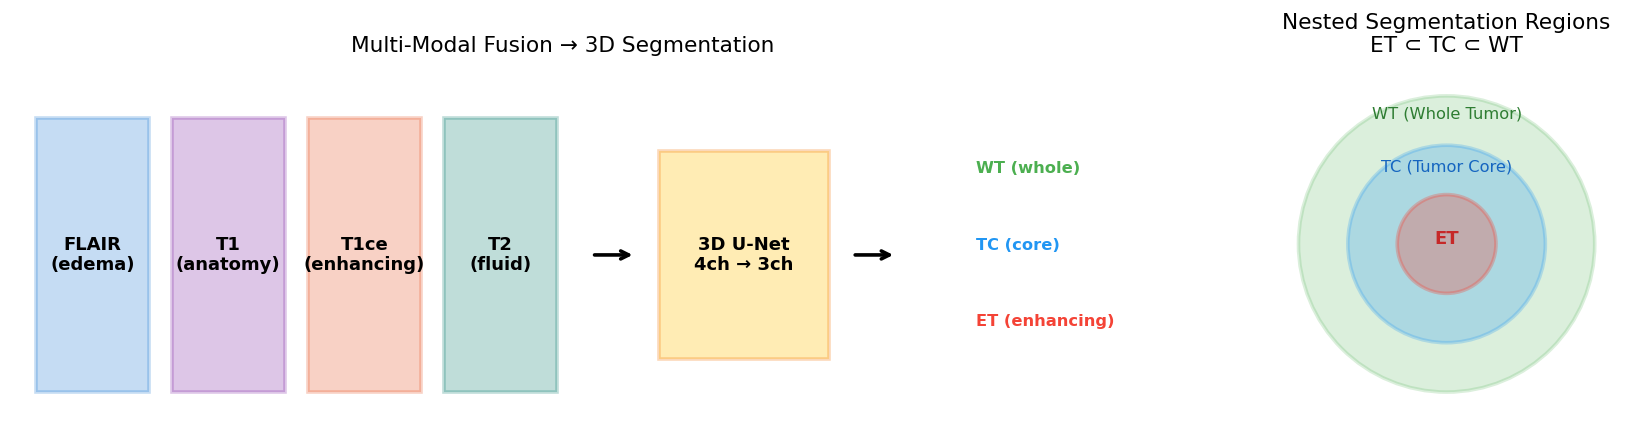

In [2]:
# Multi-modal data & segmentation task overview

fig, axes = plt.subplots(1, 2, figsize=(14, 3.5),
                         gridspec_kw={"width_ratios": [1.6, 1]})

# --- Left: multi-modal input concept ---
ax = axes[0]
modalities = ["FLAIR\n(edema)", "T1\n(anatomy)", "T1ce\n(enhancing)", "T2\n(fluid)"]
colors = ["#1976D2", "#7B1FA2", "#E64A19", "#00796B"]
for i, (mod, c) in enumerate(zip(modalities, colors)):
    rect = plt.Rectangle((i*1.2, 0), 1, 2.5, facecolor=c, alpha=0.25, edgecolor=c, lw=2)
    ax.add_patch(rect)
    ax.text(i*1.2 + 0.5, 1.25, mod, ha="center", va="center", fontsize=10, fontweight="bold")
ax.annotate("", xy=(5.3, 1.25), xytext=(4.9, 1.25),
            arrowprops=dict(arrowstyle="->", lw=2, color="black"))
rect = plt.Rectangle((5.5, 0.3), 1.5, 1.9, facecolor="#FFC107", alpha=0.3,
                      edgecolor="#F57F17", lw=2)
ax.add_patch(rect)
ax.text(6.25, 1.25, "3D U-Net\n4ch → 3ch", ha="center", va="center",
        fontsize=10, fontweight="bold")
ax.annotate("", xy=(7.6, 1.25), xytext=(7.2, 1.25),
            arrowprops=dict(arrowstyle="->", lw=2, color="black"))
labels = ["WT (whole)", "TC (core)", "ET (enhancing)"]
lcolors = ["#4CAF50", "#2196F3", "#F44336"]
for i, (lbl, lc) in enumerate(zip(labels, lcolors)):
    ax.text(8.3, 2.0 - i*0.7, lbl, fontsize=9, color=lc, fontweight="bold")
ax.set_xlim(-0.2, 9.5)
ax.set_ylim(-0.3, 3.0)
ax.set_title("Multi-Modal Fusion → 3D Segmentation", fontsize=12)
ax.axis("off")

# --- Right: nested region diagram ---
ax = axes[1]
from matplotlib.patches import Circle
c1 = Circle((0.5, 0.5), 0.45, fc="#4CAF50", alpha=0.2, ec="#4CAF50", lw=2)
c2 = Circle((0.5, 0.5), 0.30, fc="#2196F3", alpha=0.25, ec="#2196F3", lw=2)
c3 = Circle((0.5, 0.5), 0.15, fc="#F44336", alpha=0.3, ec="#F44336", lw=2)
ax.add_patch(c1); ax.add_patch(c2); ax.add_patch(c3)
ax.text(0.5, 0.88, "WT (Whole Tumor)", ha="center", fontsize=9, color="#2E7D32")
ax.text(0.5, 0.72, "TC (Tumor Core)", ha="center", fontsize=9, color="#1565C0")
ax.text(0.5, 0.5, "ET", ha="center", fontsize=10, fontweight="bold", color="#C62828")
ax.set_title("Nested Segmentation Regions\nET \u2282 TC \u2282 WT", fontsize=12)
ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 1.05)
ax.set_aspect("equal")
ax.axis("off")

plt.tight_layout()
plt.show()

---
<a id='2'></a>
## 2. Preprocessing Pipeline — Correction, Denoising, Registration

Before any ML model can work effectively, raw 3D imaging data needs systematic correction.  
This is where **domain knowledge meets algorithm design**.

```
Raw Volume  →  Bias Field Correction  →  Denoising  →  Multi-Modal Registration  →  Clean Input
```

### 2.1 Bias Field Correction (Intensity Inhomogeneity)

**Problem**: Imaging hardware produces spatially varying intensity artifacts.  
In MRI, this is caused by RF field inhomogeneity; in FIB-SEM, analogous issues include **charging artifacts** and **detector non-uniformity**.

**Solution**: N4ITK algorithm  
- Models the bias field as a smooth, low-frequency multiplicative distortion  
- Iteratively estimates and divides it out using B-spline fitting  
- Result: uniform intensity for the same tissue type regardless of spatial position

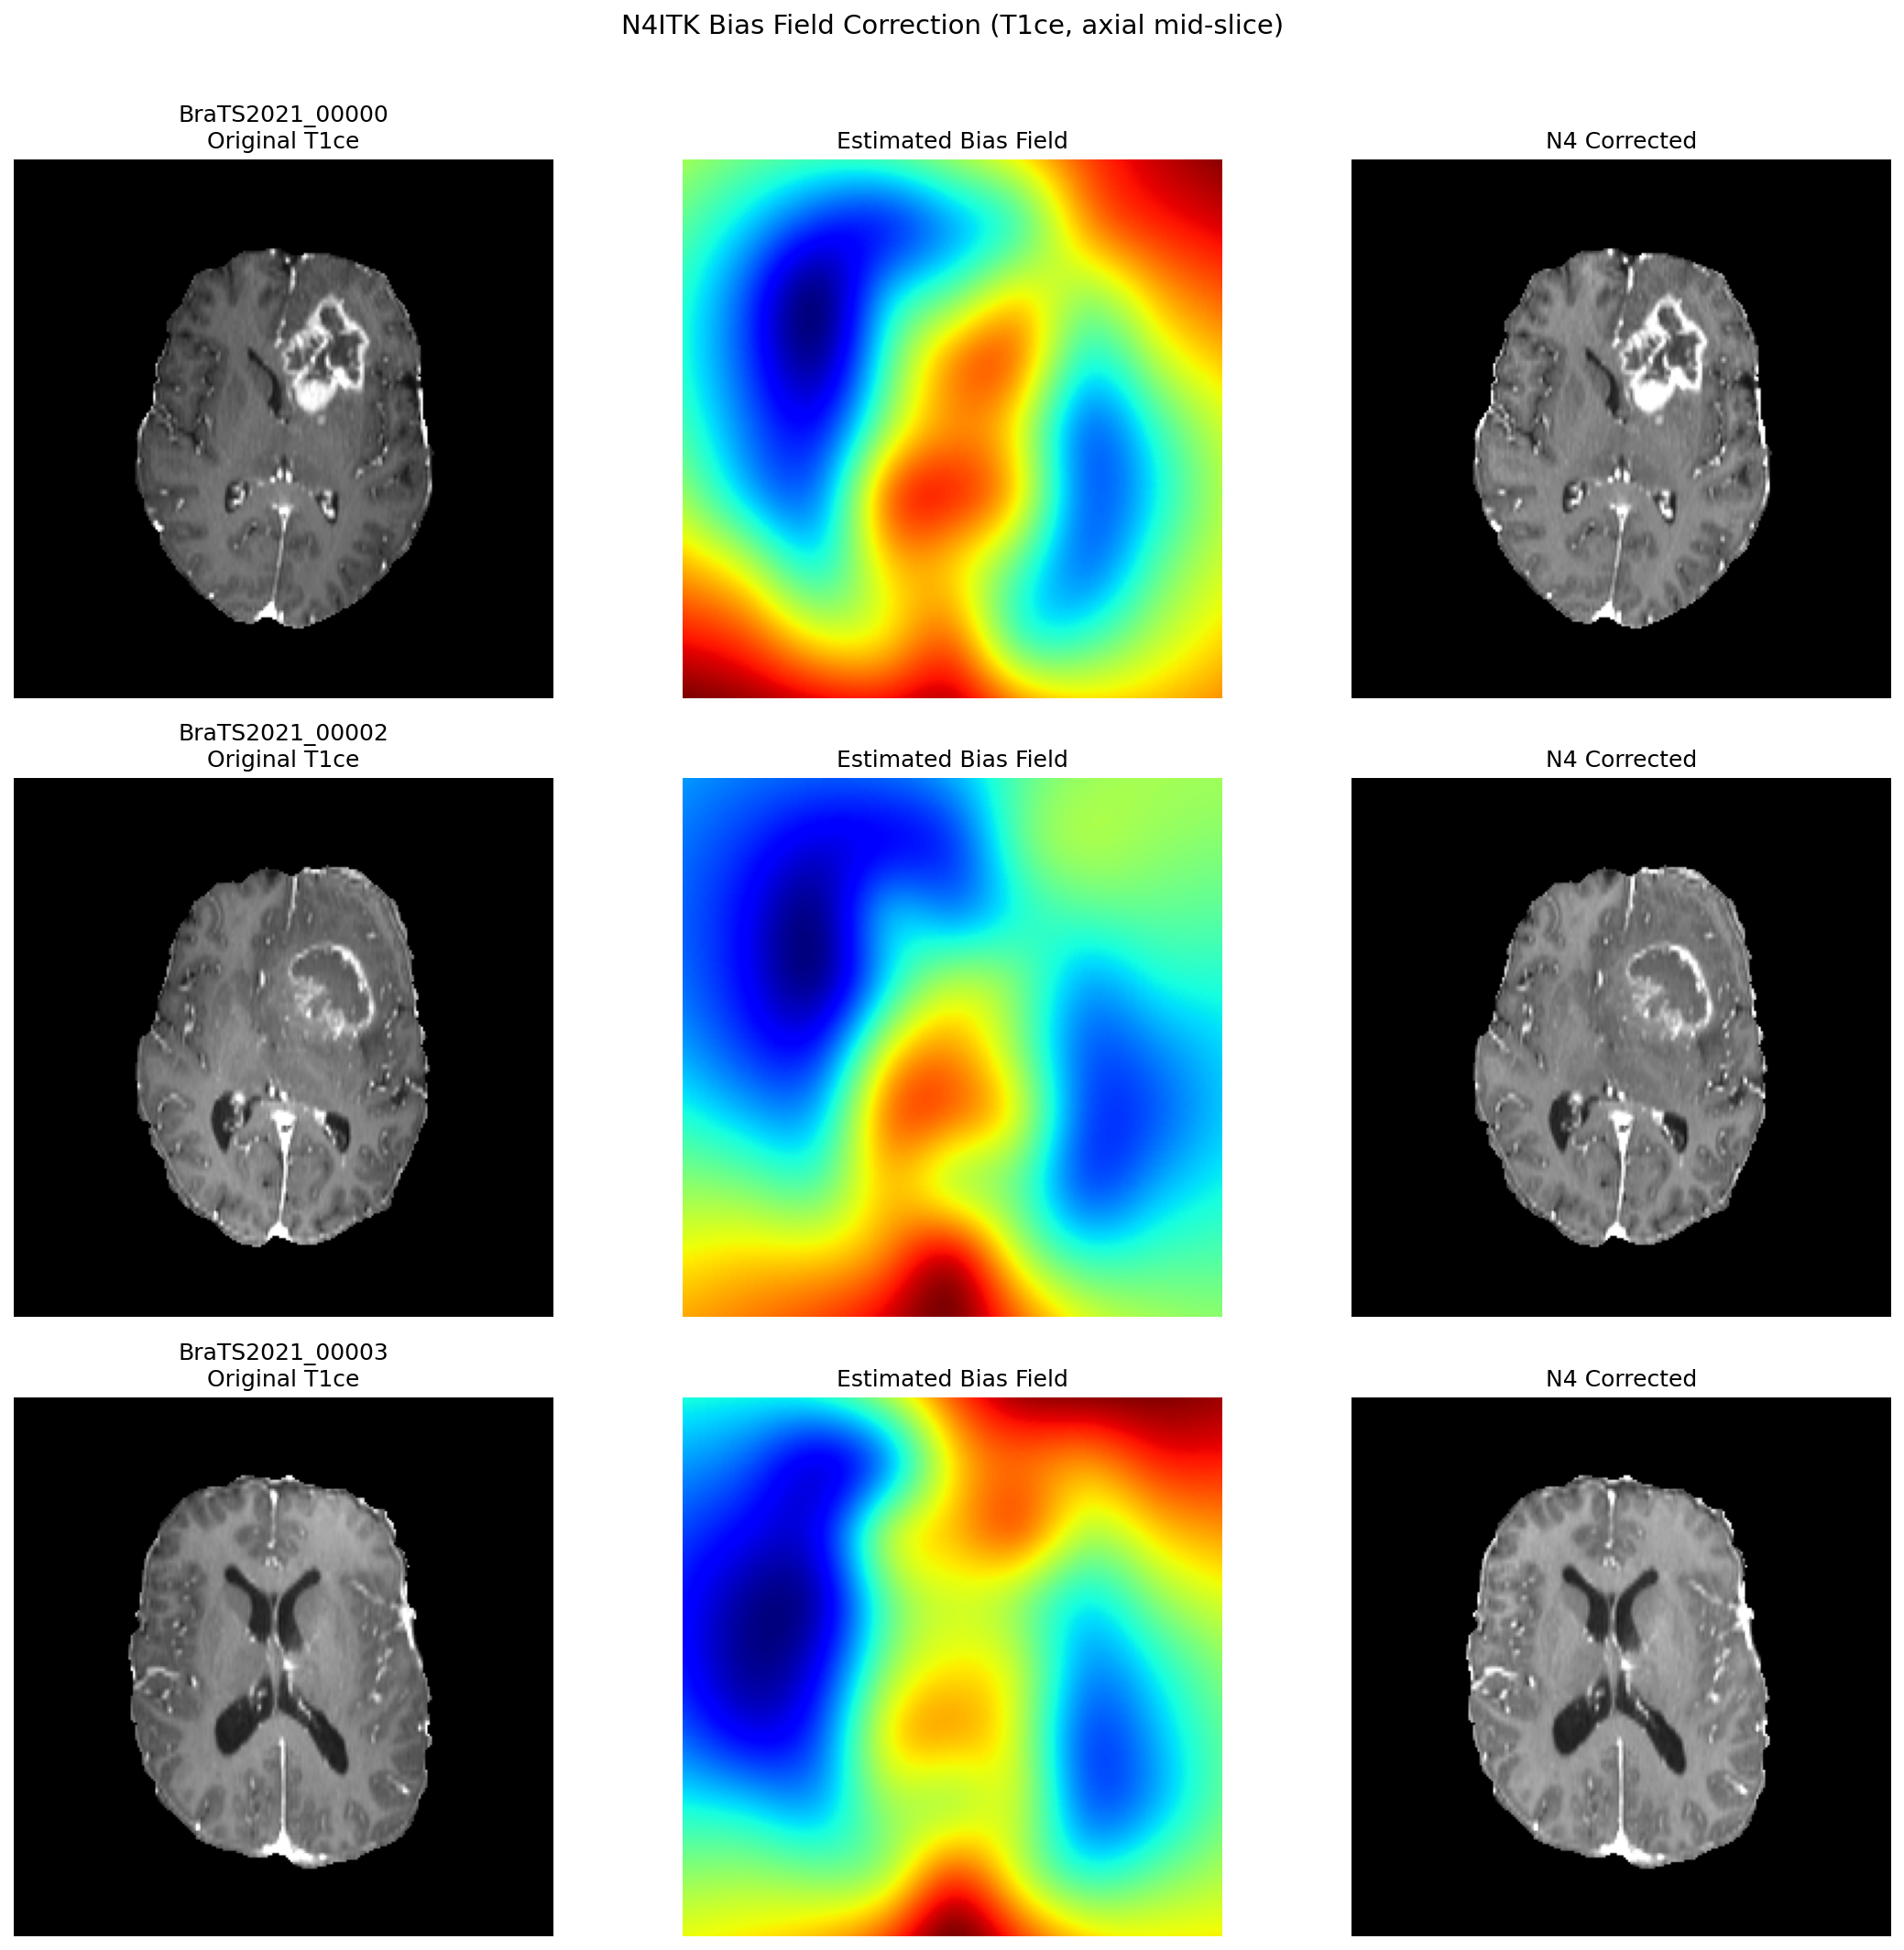

In [3]:
img_path = OUTPUTS / "bias_field" / "bias_field_comparison.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=750))
else:
    print(f"Image not found: {img_path}")

In [4]:
# N4ITK Algorithm — key implementation
code = """
# Implementation: src/preprocess/bias_field.py

import SimpleITK as sitk

def n4_bias_correction(image):
    # 1. Create Otsu mask (separate foreground from background)
    mask = sitk.OtsuThreshold(image, 0, 1, 200)
    
    # 2. N4 corrector: iterative B-spline bias field estimation
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50, 50, 30, 20])  # multi-resolution
    
    # 3. Apply — returns corrected image with uniform intensity
    corrected = corrector.Execute(image, mask)
    
    # 4. Extract the estimated bias field (for visualization / QC)
    log_bias_field = corrector.GetLogBiasFieldAsImage(image)
    bias_field = sitk.Exp(log_bias_field)  # multiplicative field
    
    return corrected, bias_field
"""
print(code)


# Implementation: src/preprocess/bias_field.py

import SimpleITK as sitk

def n4_bias_correction(image):
    # 1. Create Otsu mask (separate foreground from background)
    mask = sitk.OtsuThreshold(image, 0, 1, 200)
    
    # 2. N4 corrector: iterative B-spline bias field estimation
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50, 50, 30, 20])  # multi-resolution
    
    # 3. Apply — returns corrected image with uniform intensity
    corrected = corrector.Execute(image, mask)
    
    # 4. Extract the estimated bias field (for visualization / QC)
    log_bias_field = corrector.GetLogBiasFieldAsImage(image)
    bias_field = sitk.Exp(log_bias_field)  # multiplicative field
    
    return corrected, bias_field



### 2.2 Anisotropic Denoising

**Problem**: Thermal/electronic noise degrades image quality, especially in low-SNR regions.  
In FIB-SEM: shot noise and detector noise are major challenges at high resolution.

**Solution**: Curvature-flow anisotropic diffusion  
- Smooths noise in **homogeneous regions** while **preserving edges**  
- Unlike Gaussian blur, this respects structural boundaries  
- Critical for downstream segmentation accuracy

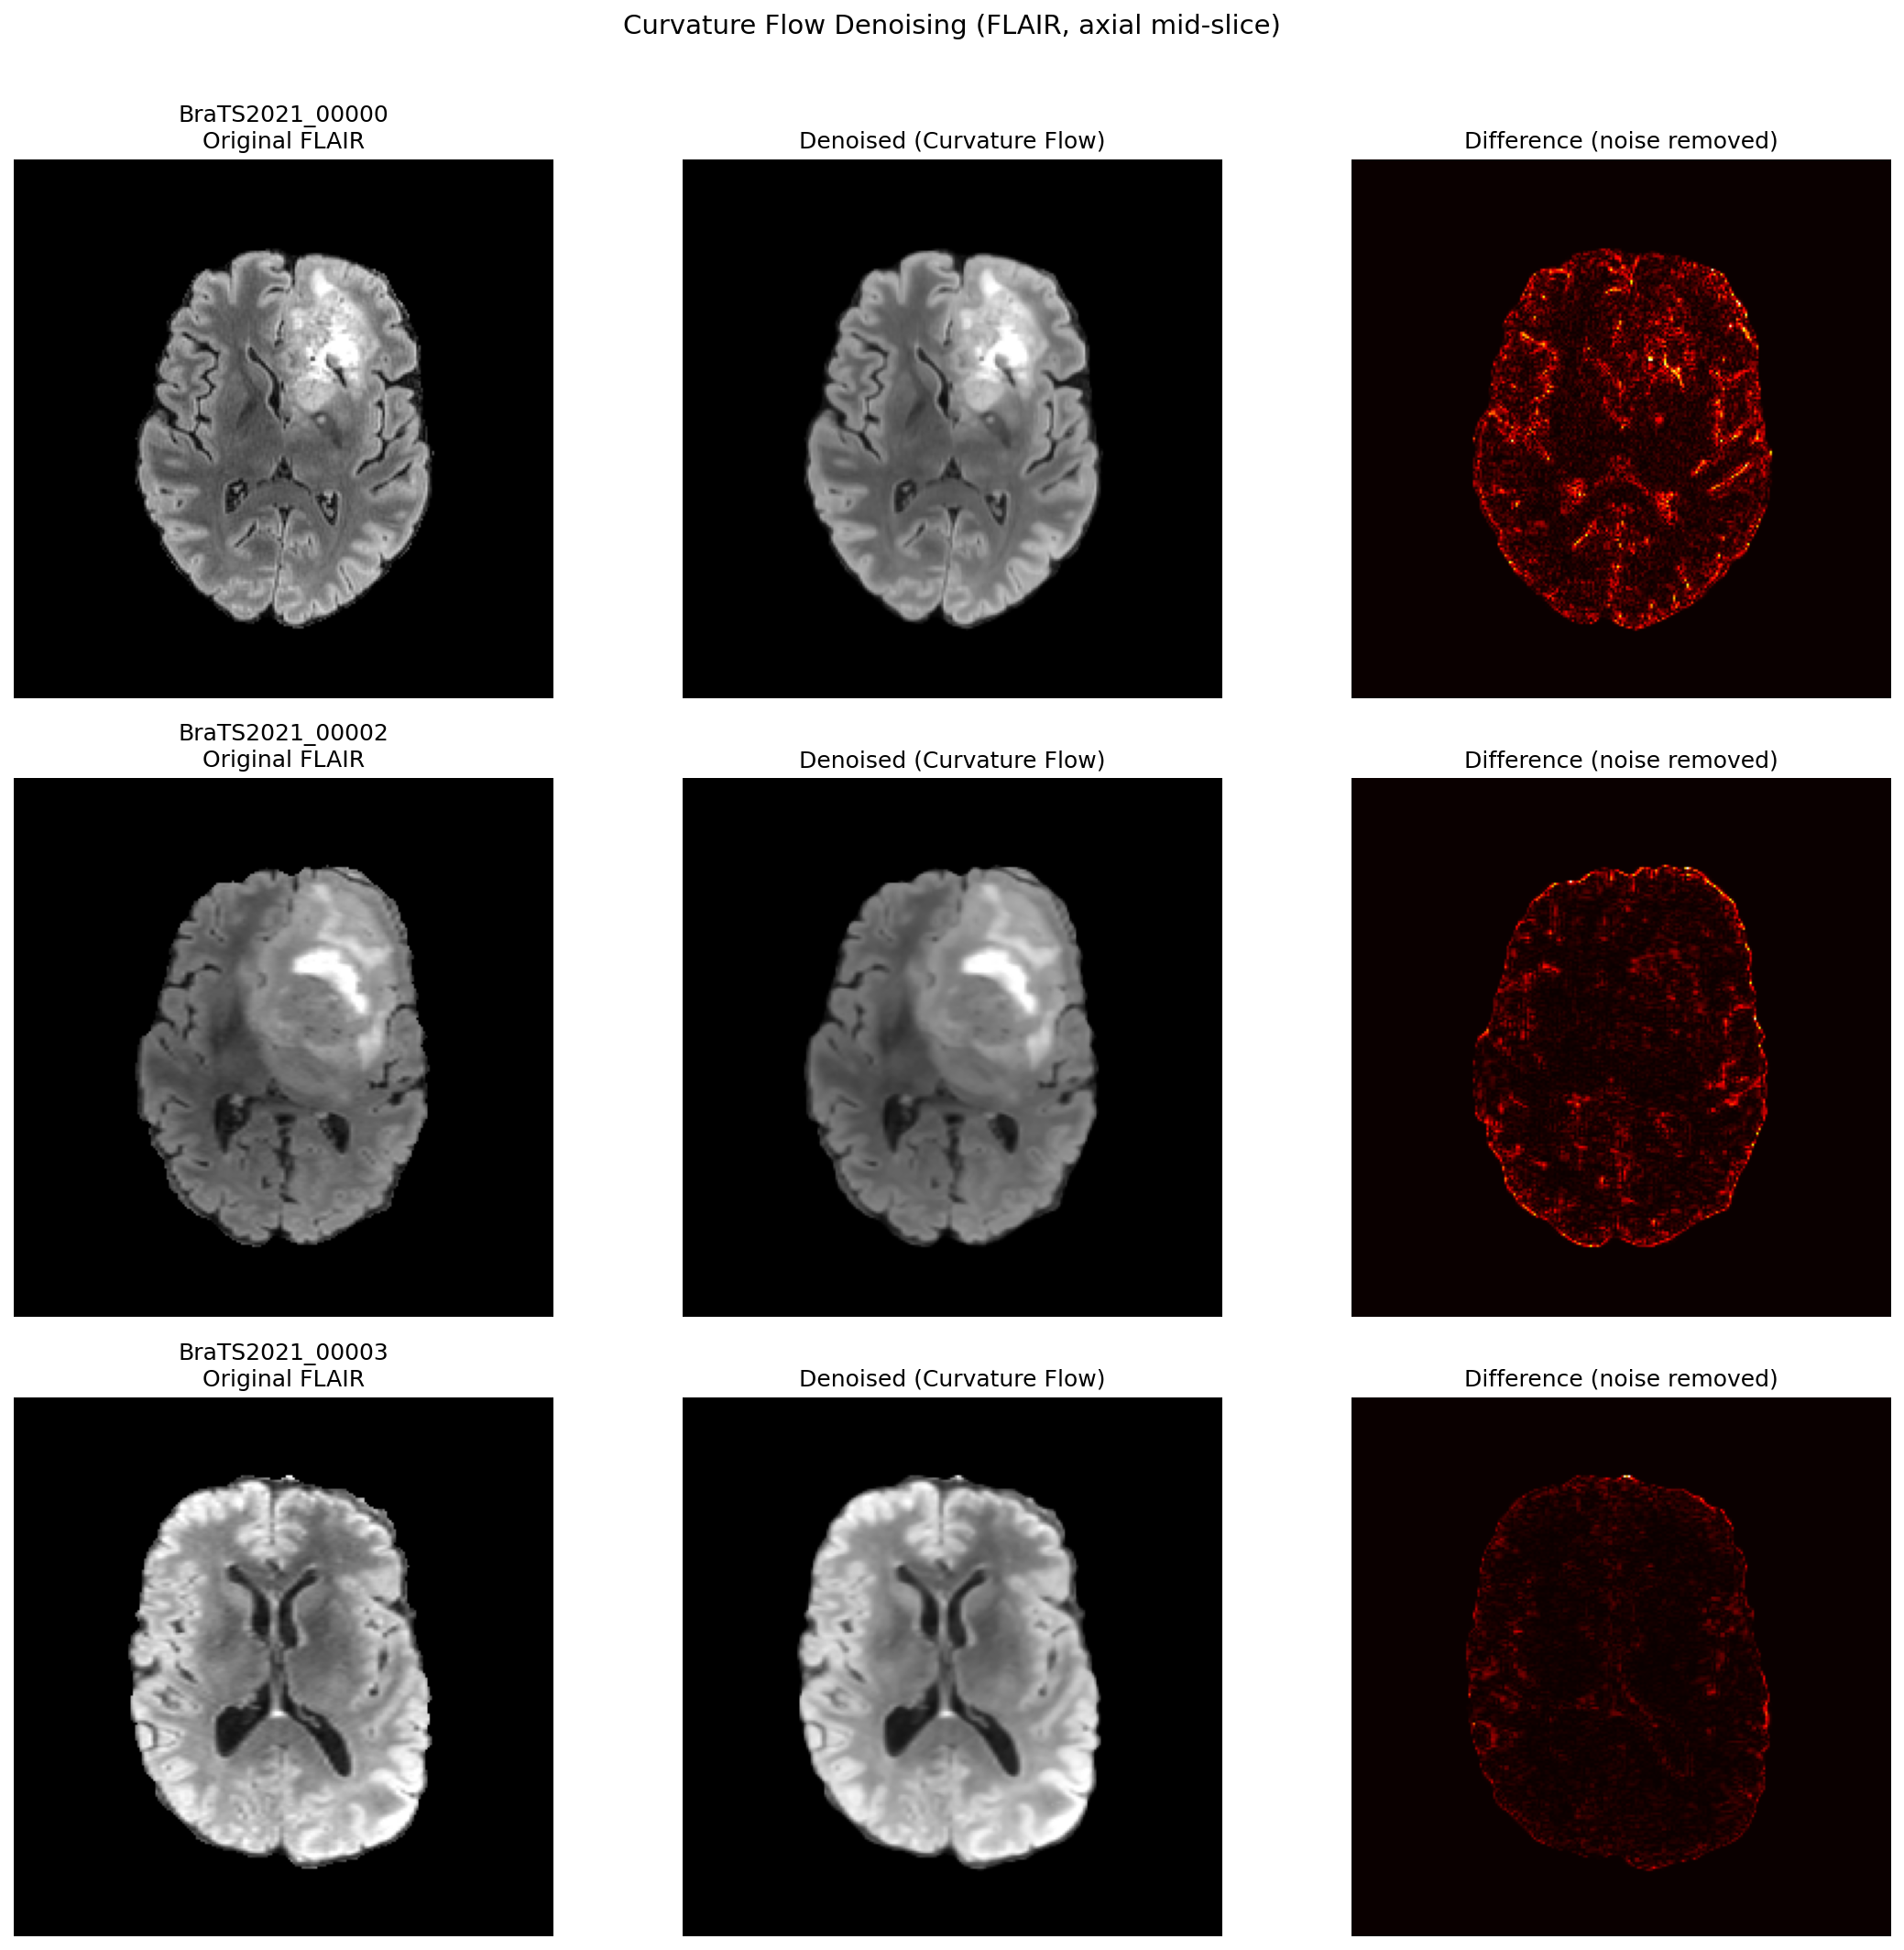

In [5]:
img_path = OUTPUTS / "denoised" / "denoising_comparison.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=750))
else:
    print(f"Image not found: {img_path}")

### 2.3 Multi-Modal Registration

**Problem**: Different modalities/detectors have spatial misalignment.  
In FIB-SEM + AFM: the two instruments image the same block face but from different geometries.

**Solution**: Rigid registration (6 DOF: 3 translation + 3 rotation)  
- **Similarity metric**: Mattes Mutual Information (works across different contrast mechanisms)  
- **Optimizer**: Regular Step Gradient Descent with multi-resolution pyramid  
- **Key insight**: Mutual information doesn't require the same intensity profile — it measures statistical dependency between modalities

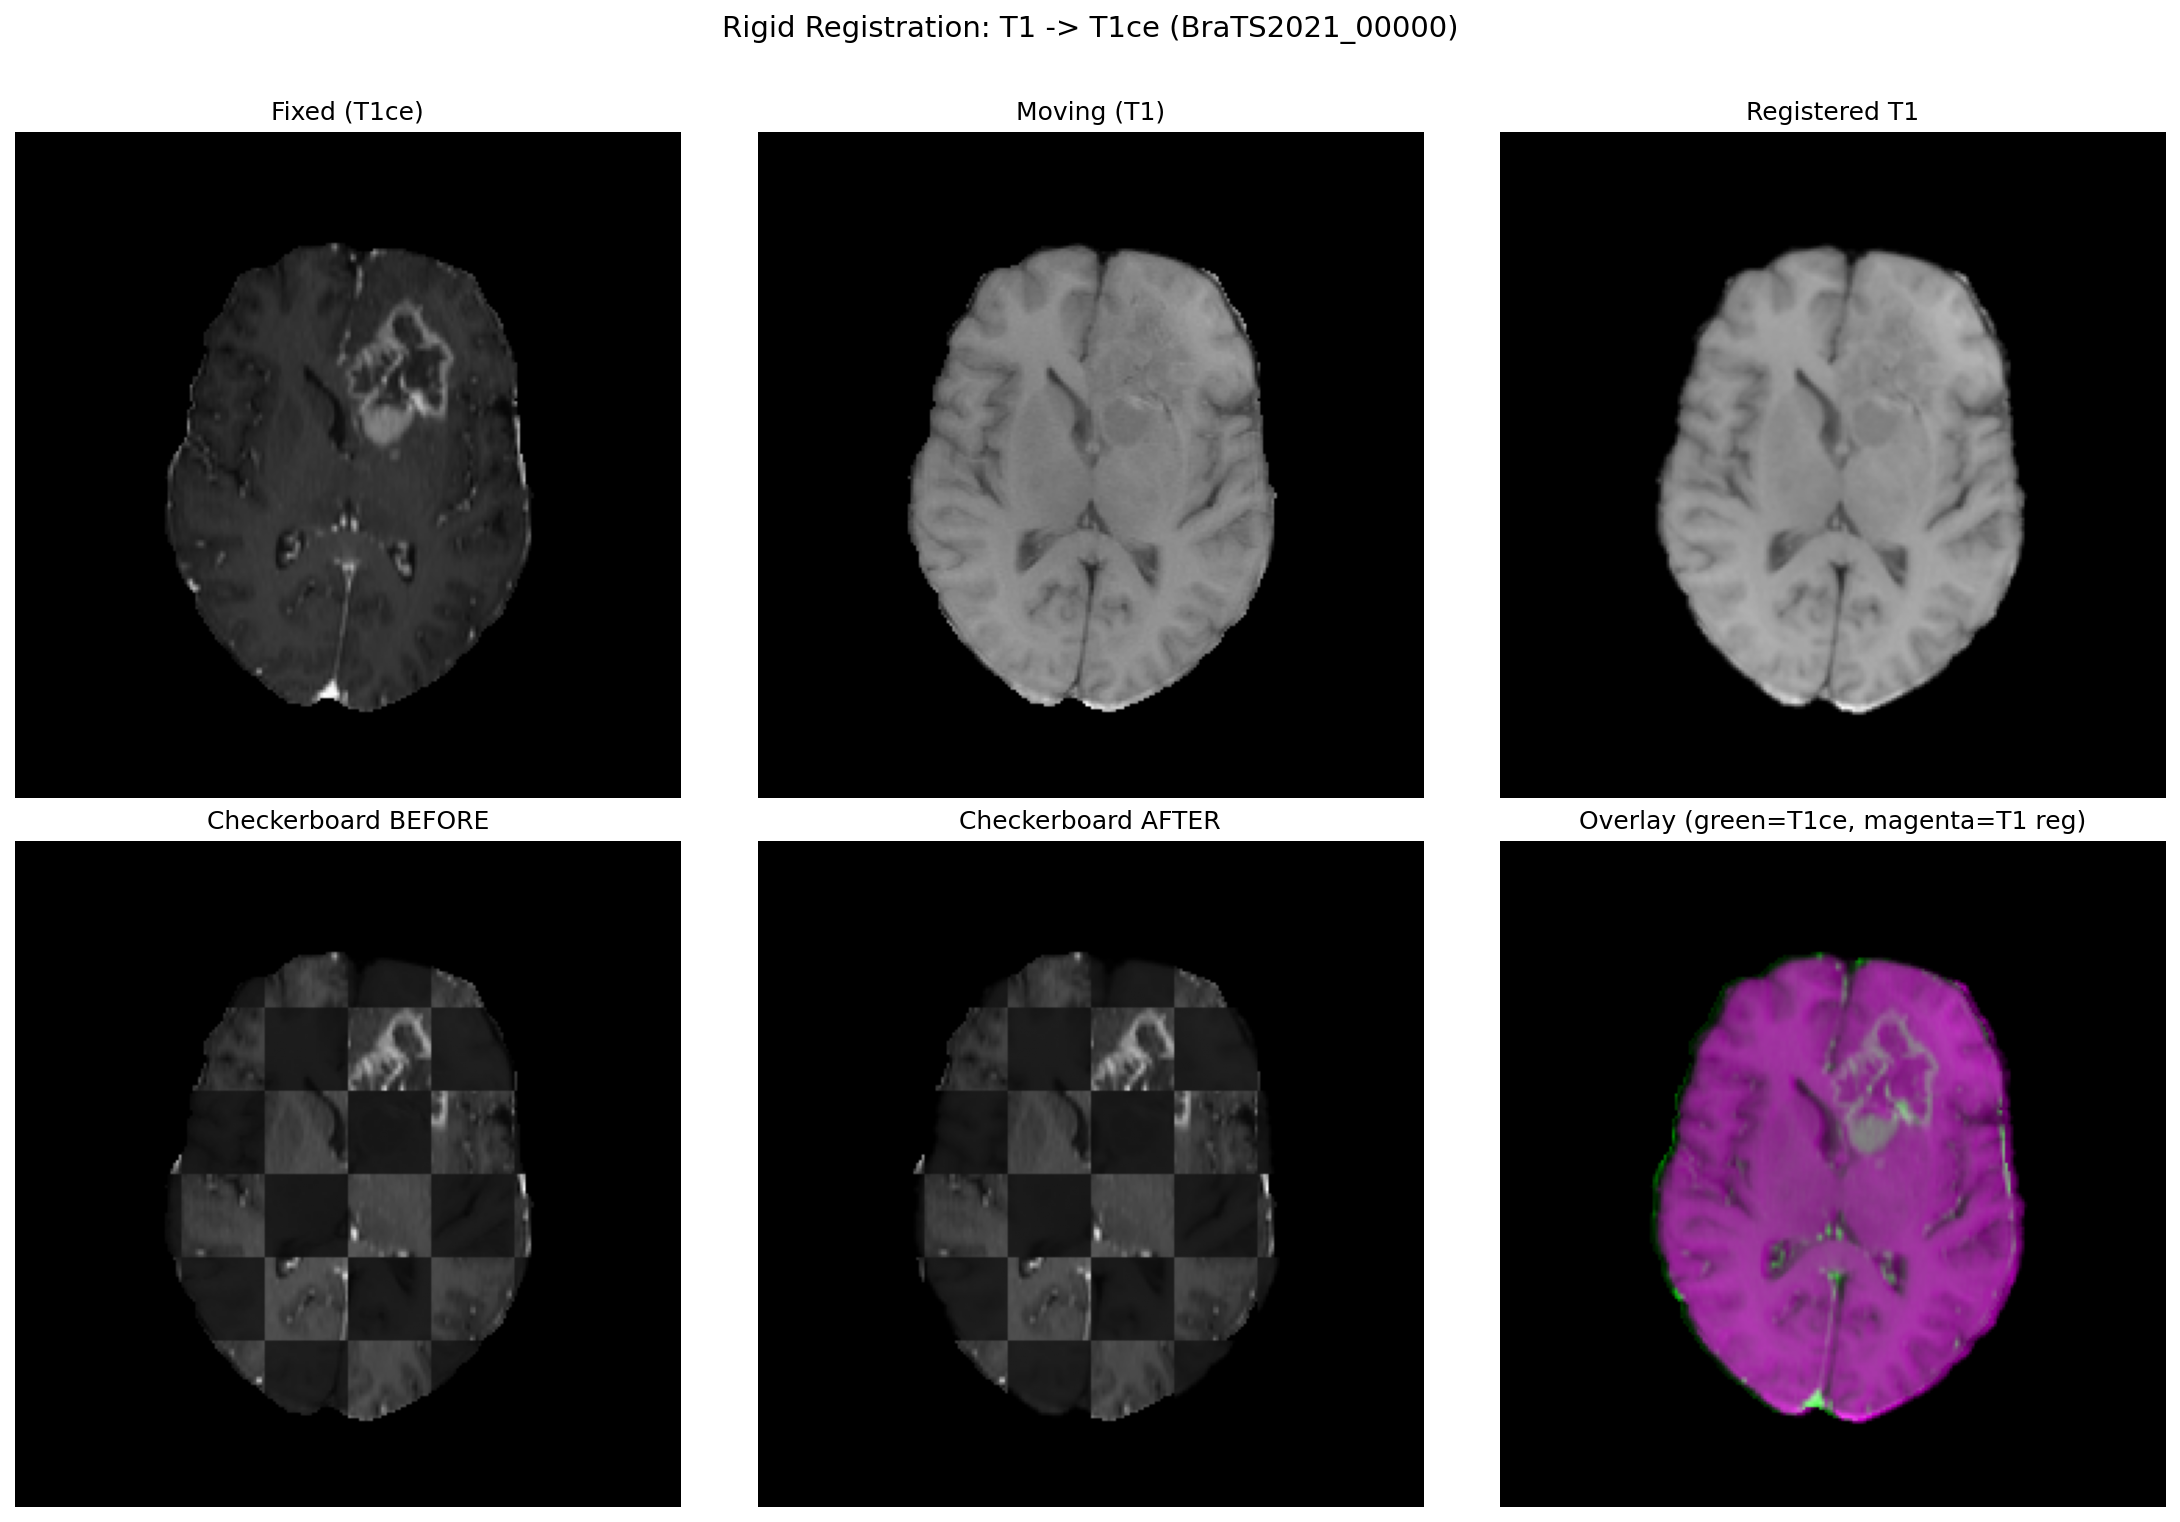

In [6]:
img_path = OUTPUTS / "registration" / "registration_demo.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=750))
else:
    print(f"Image not found: {img_path}")

In [7]:
code = """
# Implementation: src/preprocess/resample.py — Rigid Registration

import SimpleITK as sitk

def rigid_register(fixed, moving):
    # Euler3D: 6 DOF rigid transform (translation + rotation)
    initial_transform = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    registration = sitk.ImageRegistrationMethod()
    
    # Mattes Mutual Information: works across different contrast mechanisms
    # Key for multi-modal (FIB-SEM <-> AFM, or MRI T1 <-> FLAIR)
    registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration.SetMetricSamplingStrategy(registration.RANDOM)
    registration.SetMetricSamplingPercentage(0.01)  # 1% voxels — fast
    
    # Multi-resolution: coarse-to-fine for robustness
    registration.SetShrinkFactorsPerLevel([4, 2, 1])
    registration.SetSmoothingSigmasPerLevel([2, 1, 0])
    
    final_transform = registration.Execute(fixed, moving)
    registered = sitk.Resample(moving, fixed, final_transform)
    return registered
"""
print(code)


# Implementation: src/preprocess/resample.py — Rigid Registration

import SimpleITK as sitk

def rigid_register(fixed, moving):
    # Euler3D: 6 DOF rigid transform (translation + rotation)
    initial_transform = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    registration = sitk.ImageRegistrationMethod()
    
    # Mattes Mutual Information: works across different contrast mechanisms
    # Key for multi-modal (FIB-SEM <-> AFM, or MRI T1 <-> FLAIR)
    registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration.SetMetricSamplingStrategy(registration.RANDOM)
    registration.SetMetricSamplingPercentage(0.01)  # 1% voxels — fast
    
    # Multi-resolution: coarse-to-fine for robustness
    registration.SetShrinkFactorsPerLevel([4, 2, 1])
    registration.SetSmoothingSigmasPerLevel([2, 1, 0])
    
    final_transform = registration.Execute(fixed, moving)


### 2.4 Preprocessing Summary

| Step | Algorithm | What It Fixes | Analogous Problem in cryoFIB-SEM |
|------|-----------|--------------|----------------------------------|
| **Bias Correction** | N4ITK (B-spline) | Intensity inhomogeneity | Charging, curtaining, detector drift |
| **Denoising** | Curvature flow diffusion | Thermal/electronic noise | Shot noise, low-dose noise |
| **Registration** | Rigid (Euler3D + MI) | Cross-modal misalignment | FIB-SEM ↔ AFM spatial alignment |
| **Resampling** | Isotropic 1mm³ | Anisotropic voxels | Z-spacing ≠ XY-spacing in serial sections |

---
<a id='3'></a>
## 3. 3D Segmentation Model — Architecture & Design Decisions

### 3.1 Why 3D U-Net?

| Requirement | Solution |
|-------------|----------|
| Volumetric context (z-axis matters) | **3D convolutions**, not 2D slice-by-slice |
| Precise boundary localization | **Skip connections** (encoder → decoder) |
| Limited training data (731 cases) | U-Net is data-efficient vs. transformers |
| GPU memory constraint | **Patch-based training** (128³ crops) |

In [8]:
# Architecture diagram
arch = """
                         3D U-Net Architecture (19.2M parameters)

  INPUT (4, 128, 128, 128)                          OUTPUT (3, 128, 128, 128)
     |                                                    ^  
     v                                                    |  1x1x1 Conv
  [Enc1: 32ch, 128^3]  ---- skip connection ---->  [Dec1: 32ch, 128^3]
     | stride-2                                           ^ upsample+concat
  [Enc2: 64ch, 64^3]   ---- skip connection ---->  [Dec2: 64ch,  64^3]
     |                                                    ^
  [Enc3: 128ch, 32^3]  ---- skip connection ---->  [Dec3: 128ch, 32^3]
     |                                                    ^
  [Enc4: 256ch, 16^3]  ---- skip connection ---->  [Dec4: 256ch, 16^3]
     |                                                    ^
     +----------> [Bottleneck: 512ch, 8^3] >--------------+

  Each block: Conv3d(3^3) + InstanceNorm + PReLU + Conv3d(3^3) + Residual Skip
              x2 residual units per encoder/decoder level
"""
print(arch)


                         3D U-Net Architecture (19.2M parameters)

  INPUT (4, 128, 128, 128)                          OUTPUT (3, 128, 128, 128)
     |                                                    ^  
     v                                                    |  1x1x1 Conv
  [Enc1: 32ch, 128^3]  ---- skip connection ---->  [Dec1: 32ch, 128^3]
     | stride-2                                           ^ upsample+concat
  [Enc2: 64ch, 64^3]   ---- skip connection ---->  [Dec2: 64ch,  64^3]
     |                                                    ^
  [Enc3: 128ch, 32^3]  ---- skip connection ---->  [Dec3: 128ch, 32^3]
     |                                                    ^
  [Enc4: 256ch, 16^3]  ---- skip connection ---->  [Dec4: 256ch, 16^3]
     |                                                    ^
     +----------> [Bottleneck: 512ch, 8^3] >--------------+

  Each block: Conv3d(3^3) + InstanceNorm + PReLU + Conv3d(3^3) + Residual Skip
              x2 residual units per enco

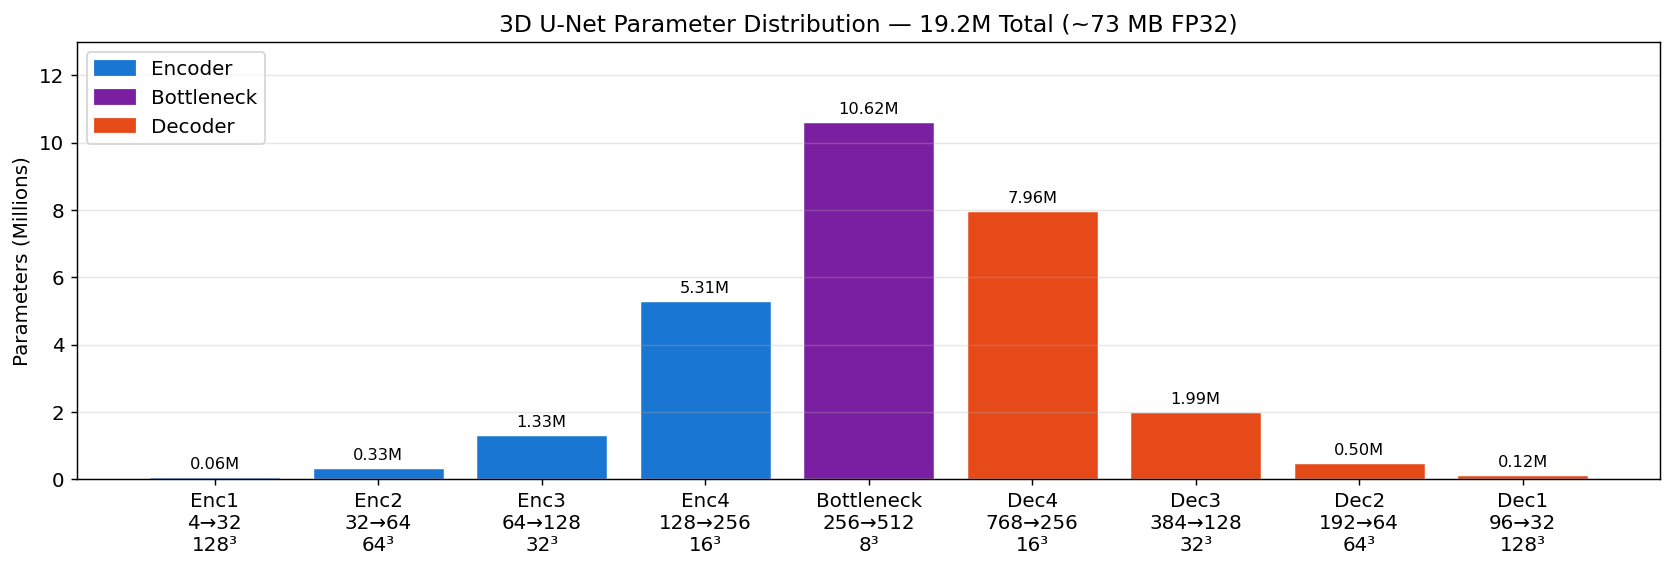

In [9]:
# Parameter distribution by layer

layers = ["Enc1\n4\u219232\n128\u00b3", "Enc2\n32\u219264\n64\u00b3",
          "Enc3\n64\u2192128\n32\u00b3", "Enc4\n128\u2192256\n16\u00b3",
          "Bottleneck\n256\u2192512\n8\u00b3",
          "Dec4\n768\u2192256\n16\u00b3", "Dec3\n384\u2192128\n32\u00b3",
          "Dec2\n192\u219264\n64\u00b3", "Dec1\n96\u219232\n128\u00b3"]
params = [0.06, 0.33, 1.33, 5.31, 10.62, 7.96, 1.99, 0.50, 0.12]
colors = ["#1976D2"]*4 + ["#7B1FA2"] + ["#E64A19"]*4

fig, ax = plt.subplots(figsize=(13, 4.5))
bars = ax.bar(layers, params, color=colors, edgecolor="white", linewidth=0.8)
for bar, p in zip(bars, params):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
            f"{p:.2f}M", ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Parameters (Millions)")
ax.set_title("3D U-Net Parameter Distribution — 19.2M Total (~73 MB FP32)")
ax.set_ylim(0, 13)
ax.legend(handles=[
    mpatches.Patch(color="#1976D2", label="Encoder"),
    mpatches.Patch(color="#7B1FA2", label="Bottleneck"),
    mpatches.Patch(color="#E64A19", label="Decoder"),
], loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Critical Design Decisions

| Decision | Choice | Why |
|----------|--------|-----|
| 2D vs 3D conv | **3D** | Target structures are 3D; z-axis context is essential |
| Normalization | **InstanceNorm** (not BatchNorm) | batch_size=2 is too small for stable batch statistics |
| Output activation | **Sigmoid** (not Softmax) | 3 regions overlap (ET \u2282 TC \u2282 WT) — multi-label, not multi-class |
| Loss function | **Dice Loss** | Directly optimizes the evaluation metric; handles class imbalance |
| Patch size | **128\u00b3** | Full volume (~240\u00b3) doesn't fit in GPU memory |

In [10]:
# The most important custom transform — label conversion
code = """
# src/data/transforms.py — The core design decision

# Why sigmoid (multi-label) instead of softmax (multi-class)?
# Because the 3 evaluation regions OVERLAP:
#   ET (label=4) is inside TC, which is inside WT
#   A voxel with label=4 belongs to ALL THREE regions simultaneously

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    \"\"\"Convert single-label (0/1/2/4) to 3-channel binary masks\"\"\"
    
    def converter(self, img):  # img shape: (1, H, W, D)
        tc = (img == 1) | (img == 4)               # Tumor Core
        wt = (img == 1) | (img == 2) | (img == 4)  # Whole Tumor
        et = (img == 4)                             # Enhancing Tumor
        return torch.cat([tc, wt, et], dim=0)       # (3, H, W, D)

# Each channel is independently predicted with sigmoid
# → A voxel CAN activate multiple channels simultaneously
"""
print(code)


# src/data/transforms.py — The core design decision

# Why sigmoid (multi-label) instead of softmax (multi-class)?
# Because the 3 evaluation regions OVERLAP:
#   ET (label=4) is inside TC, which is inside WT
#   A voxel with label=4 belongs to ALL THREE regions simultaneously

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """Convert single-label (0/1/2/4) to 3-channel binary masks"""
    
    def converter(self, img):  # img shape: (1, H, W, D)
        tc = (img == 1) | (img == 4)               # Tumor Core
        wt = (img == 1) | (img == 2) | (img == 4)  # Whole Tumor
        et = (img == 4)                             # Enhancing Tumor
        return torch.cat([tc, wt, et], dim=0)       # (3, H, W, D)

# Each channel is independently predicted with sigmoid
# → A voxel CAN activate multiple channels simultaneously



---
<a id='4'></a>
## 4. Training Engineering — Optimization at Scale

In [11]:
# Load training history
with open(REPORTS / "training_history.json") as f:
    history = json.load(f)

df_hist = pd.DataFrame(history)
epochs = df_hist["epoch"]

best_idx = df_hist["val/dice_mean"].idxmax()
best_epoch = int(df_hist.loc[best_idx, "epoch"])
best_dice  = df_hist.loc[best_idx, "val/dice_mean"]
total_hours = df_hist["epoch_time_s"].sum() / 3600

print(f"Training: {len(df_hist)} epochs recorded (epoch {int(epochs.min())} \u2192 {int(epochs.max())})")
print(f"Best model: epoch {best_epoch}, Mean Dice = {best_dice:.4f}")
print(f"Early stopped at epoch {int(epochs.max())} (patience=50)")
print(f"Total training time: {total_hours:.1f} hours")

Training: 287 epochs recorded (epoch 2 → 289)
Best model: epoch 277, Mean Dice = 0.9215
Early stopped at epoch 289 (patience=50)
Total training time: 21.2 hours


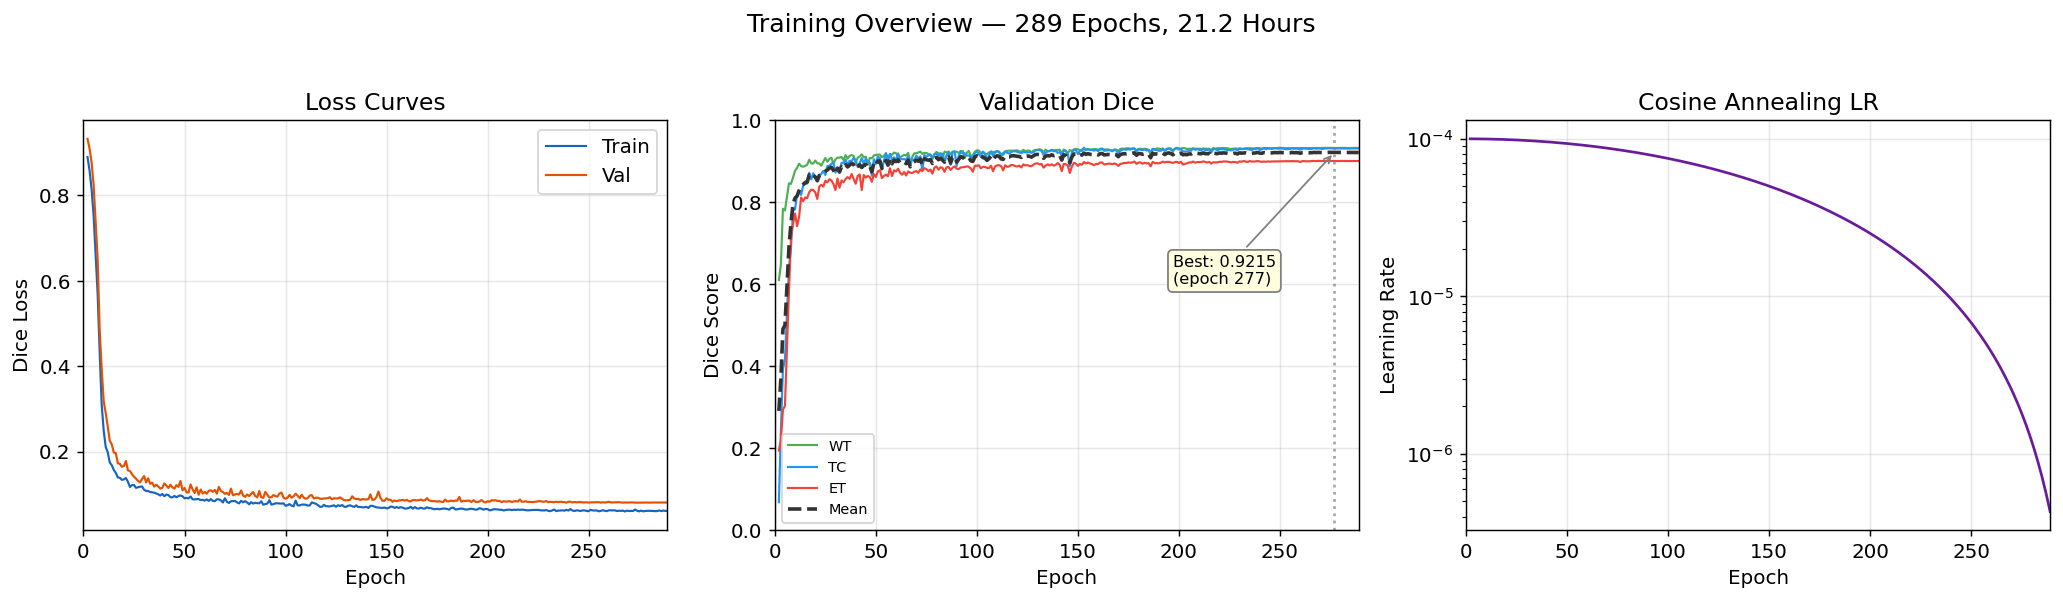

In [12]:
# Training overview: Loss + Dice + Learning Rate

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Panel 1: Loss
ax = axes[0]
ax.plot(epochs, df_hist["train/loss"], label="Train", color="#1565C0", lw=1.2)
ax.plot(epochs, df_hist["val/loss"], label="Val", color="#E65100", lw=1.2)
ax.set_xlabel("Epoch"); ax.set_ylabel("Dice Loss"); ax.set_title("Loss Curves")
ax.legend(frameon=True); ax.grid(alpha=0.3); ax.set_xlim(0, epochs.max())

# Panel 2: Dice
ax = axes[1]
for region, color in REGION_COLORS.items():
    ax.plot(epochs, df_hist[f"val/dice_{region}"], label=region, color=color, lw=1.2)
ax.plot(epochs, df_hist["val/dice_mean"], label="Mean", color="#333", lw=2, ls="--")
ax.axvline(best_epoch, color="gray", ls=":", alpha=0.7)
ax.annotate(f"Best: {best_dice:.4f}\n(epoch {best_epoch})",
            xy=(best_epoch, best_dice), xytext=(best_epoch-80, 0.6), fontsize=9,
            arrowprops=dict(arrowstyle="->", color="gray"),
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="gray"))
ax.set_xlabel("Epoch"); ax.set_ylabel("Dice Score"); ax.set_title("Validation Dice")
ax.legend(frameon=True, fontsize=8); ax.grid(alpha=0.3)
ax.set_xlim(0, epochs.max()); ax.set_ylim(0, 1.0)

# Panel 3: LR
ax = axes[2]
ax.plot(epochs, df_hist["lr"], color="#6A1B9A", lw=1.5)
ax.set_xlabel("Epoch"); ax.set_ylabel("Learning Rate"); ax.set_title("Cosine Annealing LR")
ax.set_yscale("log"); ax.grid(alpha=0.3); ax.set_xlim(0, epochs.max())

fig.suptitle(f"Training Overview — {int(epochs.max())} Epochs, {total_hours:.1f} Hours",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

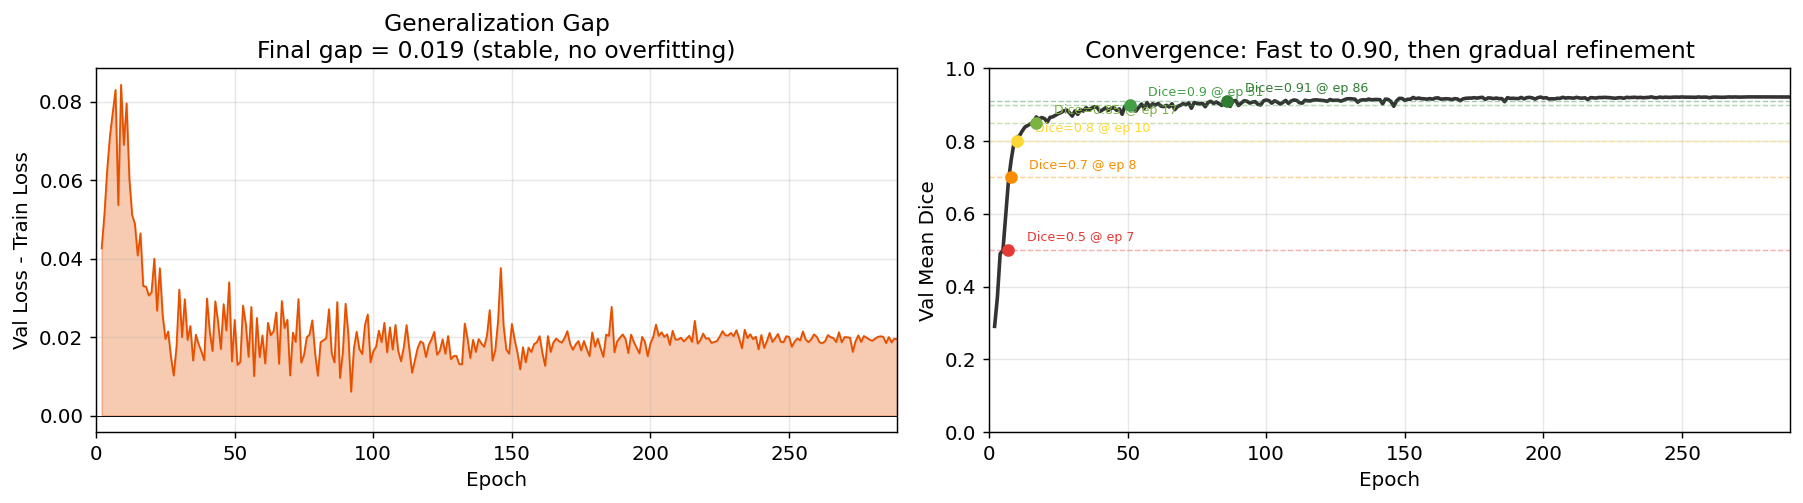

In [13]:
# Generalization gap analysis

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: gap over time
ax = axes[0]
gap = df_hist["val/loss"] - df_hist["train/loss"]
ax.fill_between(epochs, 0, gap, alpha=0.3, color="#E65100")
ax.plot(epochs, gap, color="#E65100", lw=1)
ax.axhline(0, color="black", lw=0.5)
ax.set_xlabel("Epoch"); ax.set_ylabel("Val Loss - Train Loss")
ax.set_title(f"Generalization Gap\nFinal gap = {gap.iloc[-1]:.3f} (stable, no overfitting)")
ax.grid(alpha=0.3); ax.set_xlim(0, epochs.max())

# Right: convergence speed
ax = axes[1]
ax.plot(epochs, df_hist["val/dice_mean"], color="#333", lw=2)
milestones = {0.5: "#E53935", 0.7: "#FB8C00", 0.8: "#FDD835",
              0.85: "#7CB342", 0.90: "#43A047", 0.91: "#2E7D32"}
for thresh, c in milestones.items():
    reached = df_hist[df_hist["val/dice_mean"] >= thresh]
    if len(reached) > 0:
        ep = int(reached.iloc[0]["epoch"])
        ax.axhline(thresh, color=c, ls="--", alpha=0.4, lw=0.8)
        ax.plot(ep, thresh, "o", color=c, markersize=6, zorder=5)
        ax.annotate(f"Dice={thresh} @ ep {ep}", xy=(ep, thresh),
                    xytext=(10, 5), textcoords="offset points", fontsize=7, color=c)
ax.set_xlabel("Epoch"); ax.set_ylabel("Val Mean Dice")
ax.set_title("Convergence: Fast to 0.90, then gradual refinement")
ax.set_xlim(0, epochs.max()); ax.set_ylim(0, 1.0); ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.1 Key Engineering Techniques

| Technique | What It Does | Why It Matters |
|-----------|-------------|----------------|
| **AMP (Mixed Precision)** | FP16 forward/backward, FP32 weights | 40% less GPU memory, 20% faster |
| **CosineAnnealingLR** | LR: 1e-4 → 1e-7 smoothly | Better convergence than step decay |
| **Early Stopping** (patience=50) | Stop when validation plateaus | Prevents overfitting, saves compute |
| **Checkpoint Resume** | Save model + optimizer + scaler + scheduler | Crash-safe; resumed training after interruption |
| **CacheDataset** (30% cache) | Keep frequently used data in RAM | 3x faster I/O for NIfTI loading |
| **14-step Transform Pipeline** | Augmentation + normalization | Regularization for small dataset |

In [14]:
# AMP training loop — core implementation
code = """
# src/train.py — Mixed precision training loop

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()  # Prevents FP16 gradient underflow

for batch in dataloader:
    inputs = cat_modalities(batch)     # (B, 4, 128, 128, 128)
    labels = batch["seg"]              # (B, 3, 128, 128, 128)
    
    optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
    
    with autocast("cuda"):             # Forward pass in FP16
        loss = dice_loss(model(inputs), labels)
    
    scaler.scale(loss).backward()      # Backward in FP16 with scaling
    scaler.step(optimizer)             # Update weights in FP32
    scaler.update()                    # Adapt scale factor dynamically
"""
print(code)


# src/train.py — Mixed precision training loop

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()  # Prevents FP16 gradient underflow

for batch in dataloader:
    inputs = cat_modalities(batch)     # (B, 4, 128, 128, 128)
    labels = batch["seg"]              # (B, 3, 128, 128, 128)
    
    optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
    
    with autocast("cuda"):             # Forward pass in FP16
        loss = dice_loss(model(inputs), labels)
    
    scaler.scale(loss).backward()      # Backward in FP16 with scaling
    scaler.step(optimizer)             # Update weights in FP32
    scaler.update()                    # Adapt scale factor dynamically



In [15]:
# Sliding window inference — how to handle full 3D volumes
code = """
# src/infer.py — Sliding Window Inference for full-resolution 3D volumes

# Problem: Full volume (~240x240x155) doesn't fit in GPU memory
# Solution: Slide a 128^3 window across the volume with overlap

from monai.inferers import sliding_window_inference

outputs = sliding_window_inference(
    inputs=full_volume,          # (1, 4, 240, 240, 155)
    roi_size=[128, 128, 128],    # Same as training patch size
    sw_batch_size=4,             # Process 4 patches simultaneously
    overlap=0.5,                 # 50% overlap between windows
    mode="gaussian",             # Gaussian-weighted blending
)

# How it works:
#  1. Slide 128^3 window with step=64 (50% overlap)
#  2. Each window → independent forward pass
#  3. Overlapping regions → Gaussian-weighted average
#     (center voxels get higher weight, edges get lower)
#  4. Result: seamless full-resolution prediction, no edge artifacts
#
# This approach scales to ANY volume size — critical for large FIB-SEM stacks
"""
print(code)


# src/infer.py — Sliding Window Inference for full-resolution 3D volumes

# Problem: Full volume (~240x240x155) doesn't fit in GPU memory
# Solution: Slide a 128^3 window across the volume with overlap

from monai.inferers import sliding_window_inference

outputs = sliding_window_inference(
    inputs=full_volume,          # (1, 4, 240, 240, 155)
    roi_size=[128, 128, 128],    # Same as training patch size
    sw_batch_size=4,             # Process 4 patches simultaneously
    overlap=0.5,                 # 50% overlap between windows
    mode="gaussian",             # Gaussian-weighted blending
)

# How it works:
#  1. Slide 128^3 window with step=64 (50% overlap)
#  2. Each window → independent forward pass
#  3. Overlapping regions → Gaussian-weighted average
#     (center voxels get higher weight, edges get lower)
#  4. Result: seamless full-resolution prediction, no edge artifacts
#
# This approach scales to ANY volume size — critical for large FIB-SEM stacks



---
<a id='5'></a>
## 5. Results & Quantitative Evaluation

In [16]:
# Load evaluation results
df_results = pd.read_csv(REPORTS / "results.csv")
df_cases = df_results[df_results["case_id"] != "MEAN"].copy()
df_mean  = df_results[df_results["case_id"] == "MEAN"].copy()

n_cases = df_cases["case_id"].nunique()

# Summary table
print(f"Validated on {n_cases} held-out cases (20% split, seed=42)")
print(f"{'='*55}")
for _, row in df_mean.iterrows():
    print(f"  {row['region']:>3s}:  Dice={row['dice']:.4f}  IoU={row['iou']:.4f}  "
          f"HD95={row['hd95']:.2f}mm  Sensitivity={row['sensitivity']:.4f}")
print(f"{'='*55}")
overall = df_mean["dice"].mean()
print(f"  Overall Mean Dice = {overall:.4f}")

Validated on 147 held-out cases (20% split, seed=42)
   WT:  Dice=0.9250  IoU=0.8674  HD95=6.80mm  Sensitivity=0.9212
   TC:  Dice=0.9213  IoU=0.8667  HD95=5.31mm  Sensitivity=0.9347
   ET:  Dice=0.8913  IoU=0.8148  HD95=3.73mm  Sensitivity=0.9085
  ALL:  Dice=0.9126  IoU=0.8496  HD95=5.28mm  Sensitivity=0.9215
  Overall Mean Dice = 0.9126


### 5.1 Visual Comparison — Ground Truth vs. Prediction

4 representative cases (best, 75th percentile, median, 25th percentile)

Left: FLAIR input | Middle: Ground Truth | Right: Model Prediction

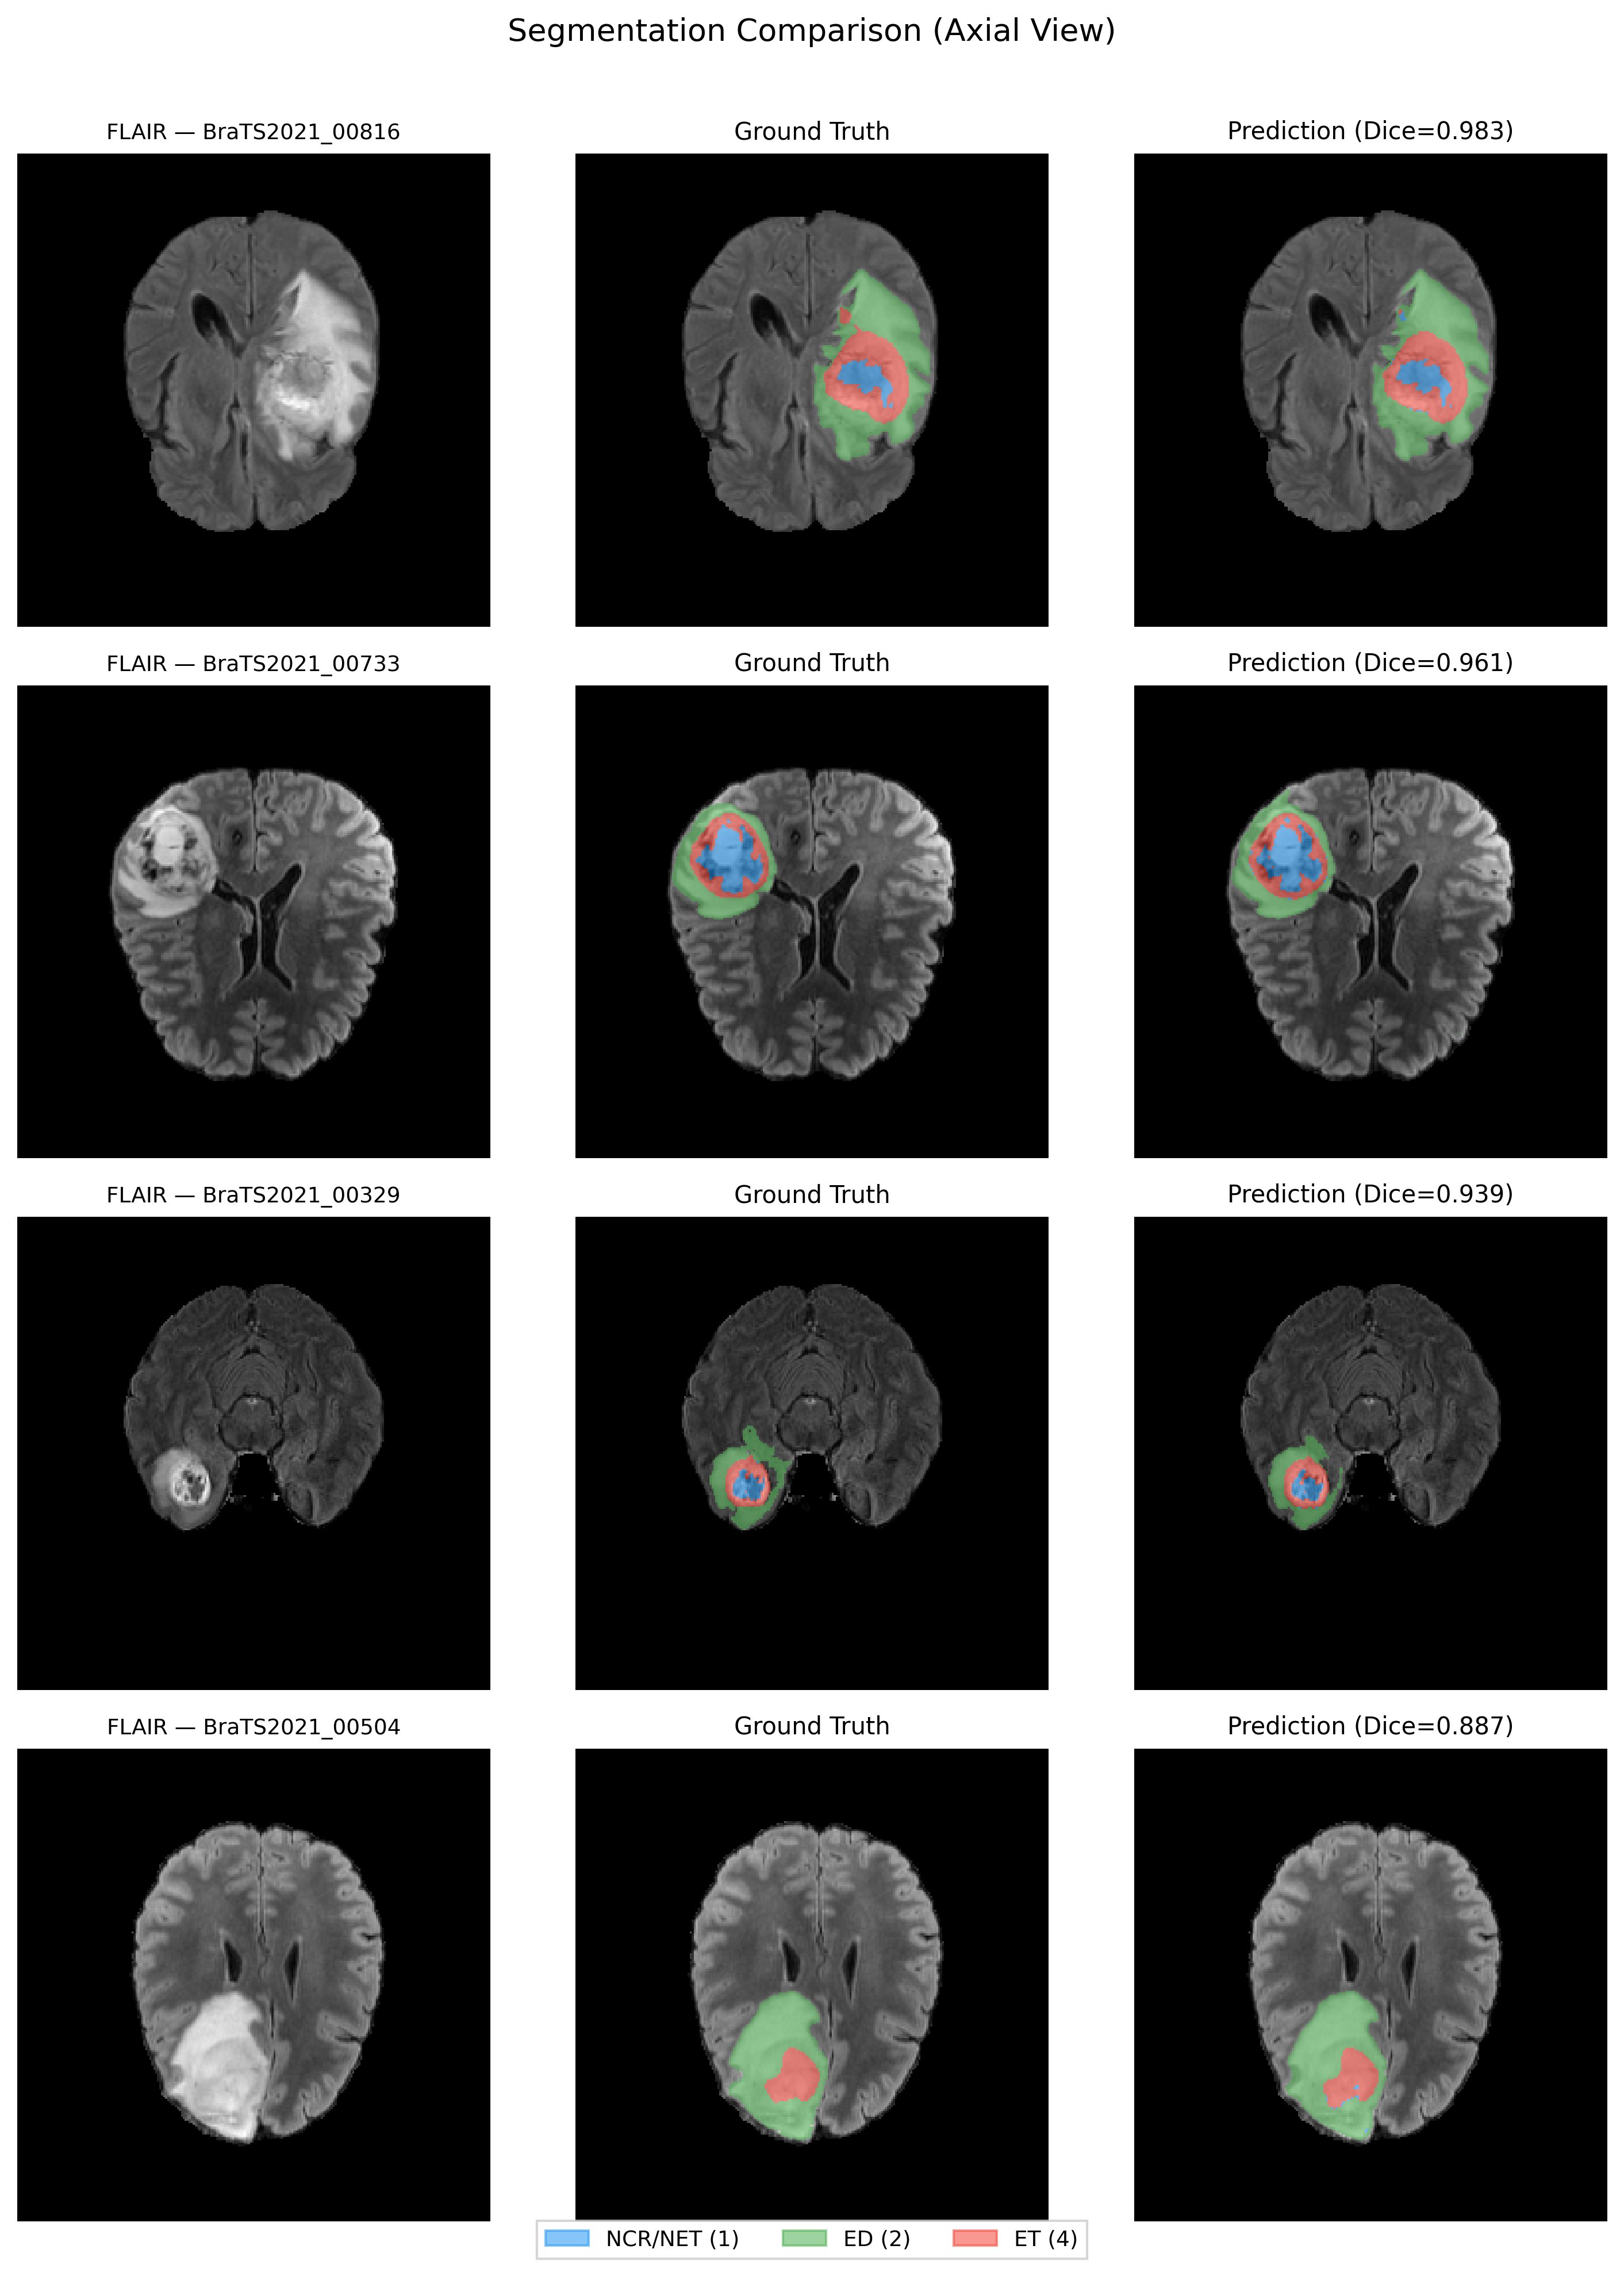

In [17]:
# Segmentation visualization: GT vs Prediction
display(Markdown("### 5.1 Visual Comparison — Ground Truth vs. Prediction"))
display(Markdown(
    "4 representative cases (best, 75th percentile, median, 25th percentile)\n\n"
    "Left: FLAIR input | Middle: Ground Truth | Right: Model Prediction"
))

img_path = FIGURES / "segmentation_comparison.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=700))
else:
    print(f"Image not found: {img_path}")

### 5.2 Multi-View 3D Visualization (Best Case, Dice=0.983)

Top: Ground Truth | Bottom: Prediction — Axial, Coronal, Sagittal

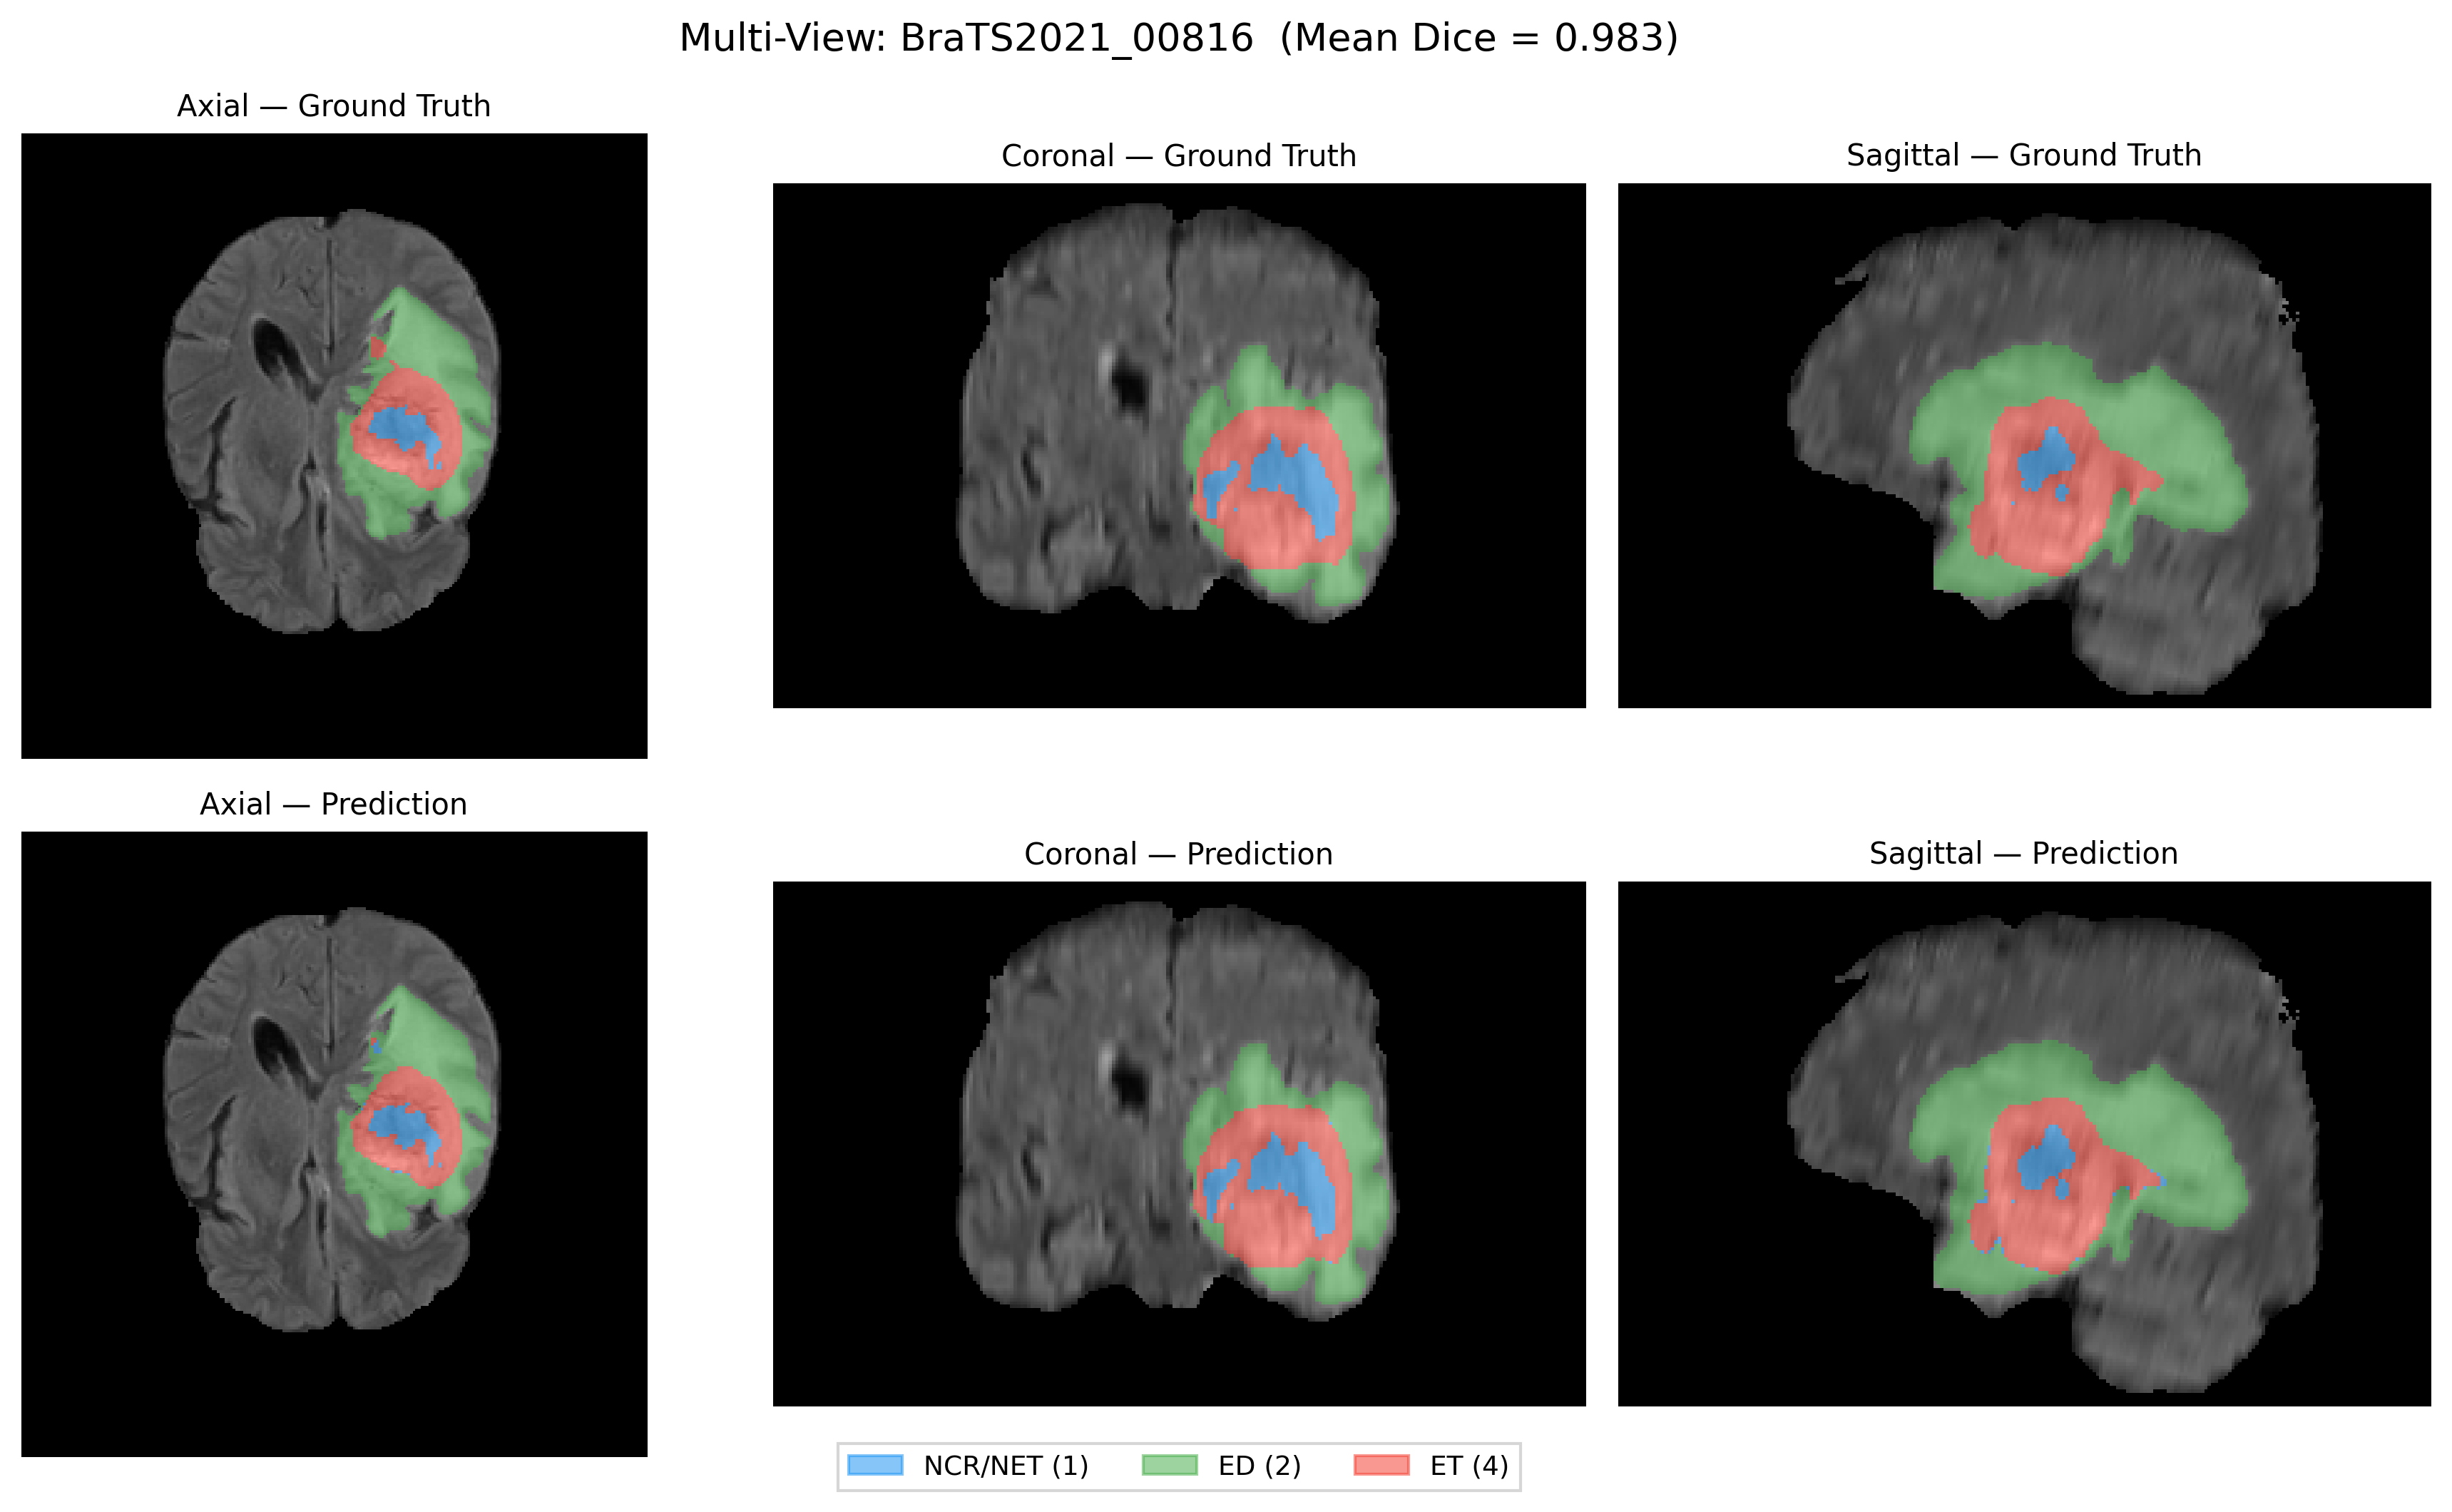

In [18]:
# Multi-view 3D visualization of best case
display(Markdown("### 5.2 Multi-View 3D Visualization (Best Case, Dice=0.983)"))
display(Markdown("Top: Ground Truth | Bottom: Prediction — Axial, Coronal, Sagittal"))

img_path = FIGURES / "multi_view_prediction.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=750))
else:
    print(f"Image not found: {img_path}")

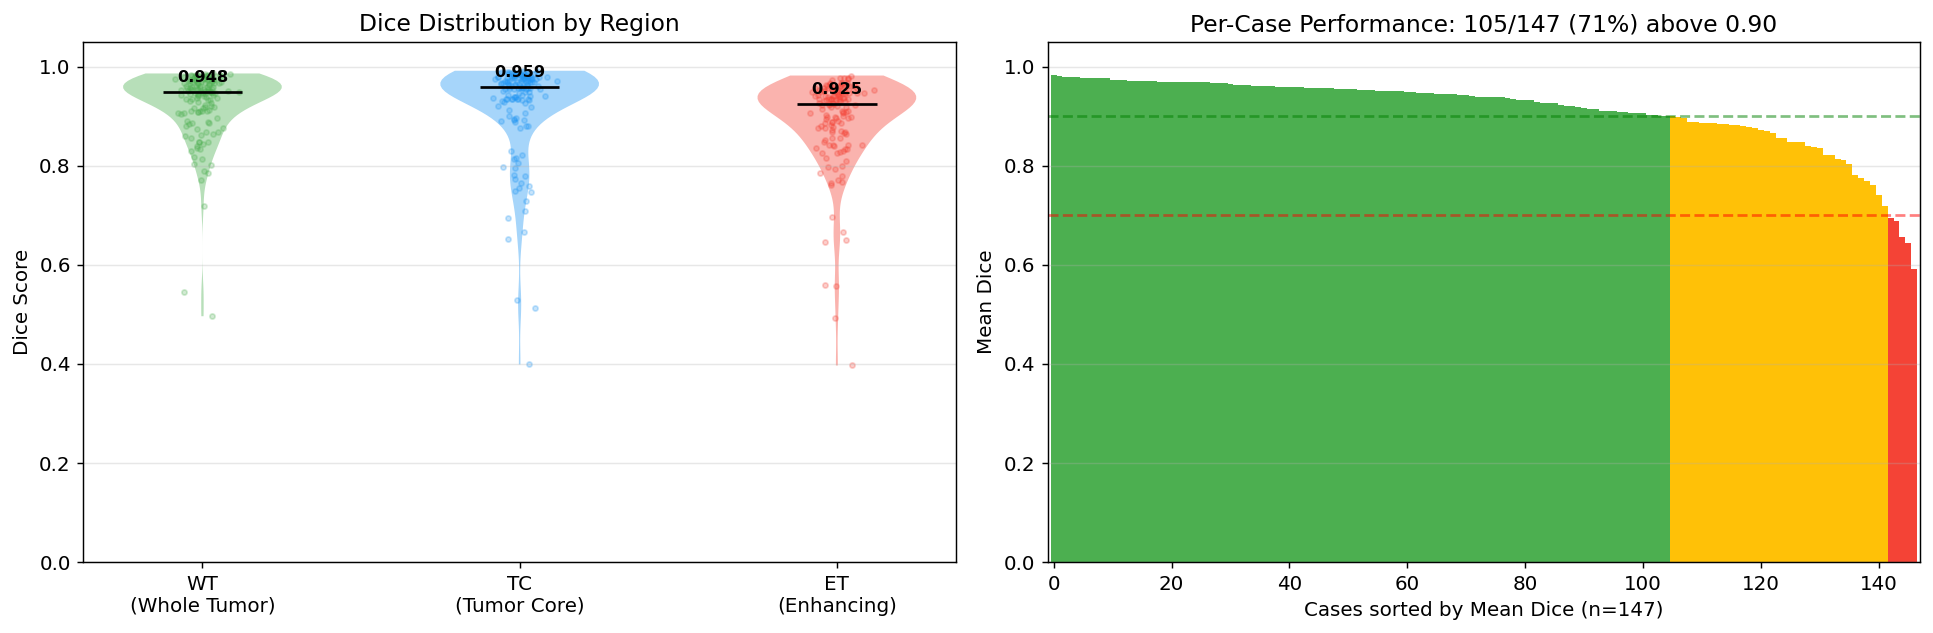

In [19]:
# Dice distribution + per-case ranking

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: Violin plot
ax = axes[0]
plot_data = []
for region in ["WT", "TC", "ET"]:
    vals = df_cases[df_cases["region"] == region]["dice"].dropna().values
    plot_data.append(vals)
parts = ax.violinplot(plot_data, positions=[1, 2, 3], showmedians=True, showextrema=False)
for pc, region in zip(parts["bodies"], ["WT", "TC", "ET"]):
    pc.set_facecolor(REGION_COLORS[region]); pc.set_alpha(0.4)
parts["cmedians"].set_color("black")
for i, (region, vals) in enumerate(zip(["WT", "TC", "ET"], plot_data)):
    jitter = np.random.default_rng(42).normal(0, 0.04, len(vals))
    ax.scatter(np.full_like(vals, i+1) + jitter, vals,
              color=REGION_COLORS[region], alpha=0.25, s=8)
    ax.text(i+1, np.median(vals) + 0.02, f"{np.median(vals):.3f}",
            ha="center", fontsize=9, fontweight="bold")
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["WT\n(Whole Tumor)", "TC\n(Tumor Core)", "ET\n(Enhancing)"])
ax.set_ylabel("Dice Score"); ax.set_title("Dice Distribution by Region")
ax.set_ylim(0, 1.05); ax.grid(axis="y", alpha=0.3)

# Right: Per-case ranking
ax = axes[1]
case_mean = df_cases.groupby("case_id")["dice"].mean().sort_values(ascending=False)
colors = ["#4CAF50" if d >= 0.9 else "#FFC107" if d >= 0.7 else "#F44336" for d in case_mean]
ax.bar(range(len(case_mean)), case_mean.values, color=colors, width=1.0)
ax.axhline(0.9, color="green", ls="--", alpha=0.5)
ax.axhline(0.7, color="red", ls="--", alpha=0.5)
n_good = (case_mean >= 0.9).sum()
ax.set_xlabel(f"Cases sorted by Mean Dice (n={len(case_mean)})")
ax.set_ylabel("Mean Dice")
ax.set_title(f"Per-Case Performance: {n_good}/{len(case_mean)} ({100*n_good/len(case_mean):.0f}%) above 0.90")
ax.set_xlim(-1, len(case_mean)); ax.set_ylim(0, 1.05); ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

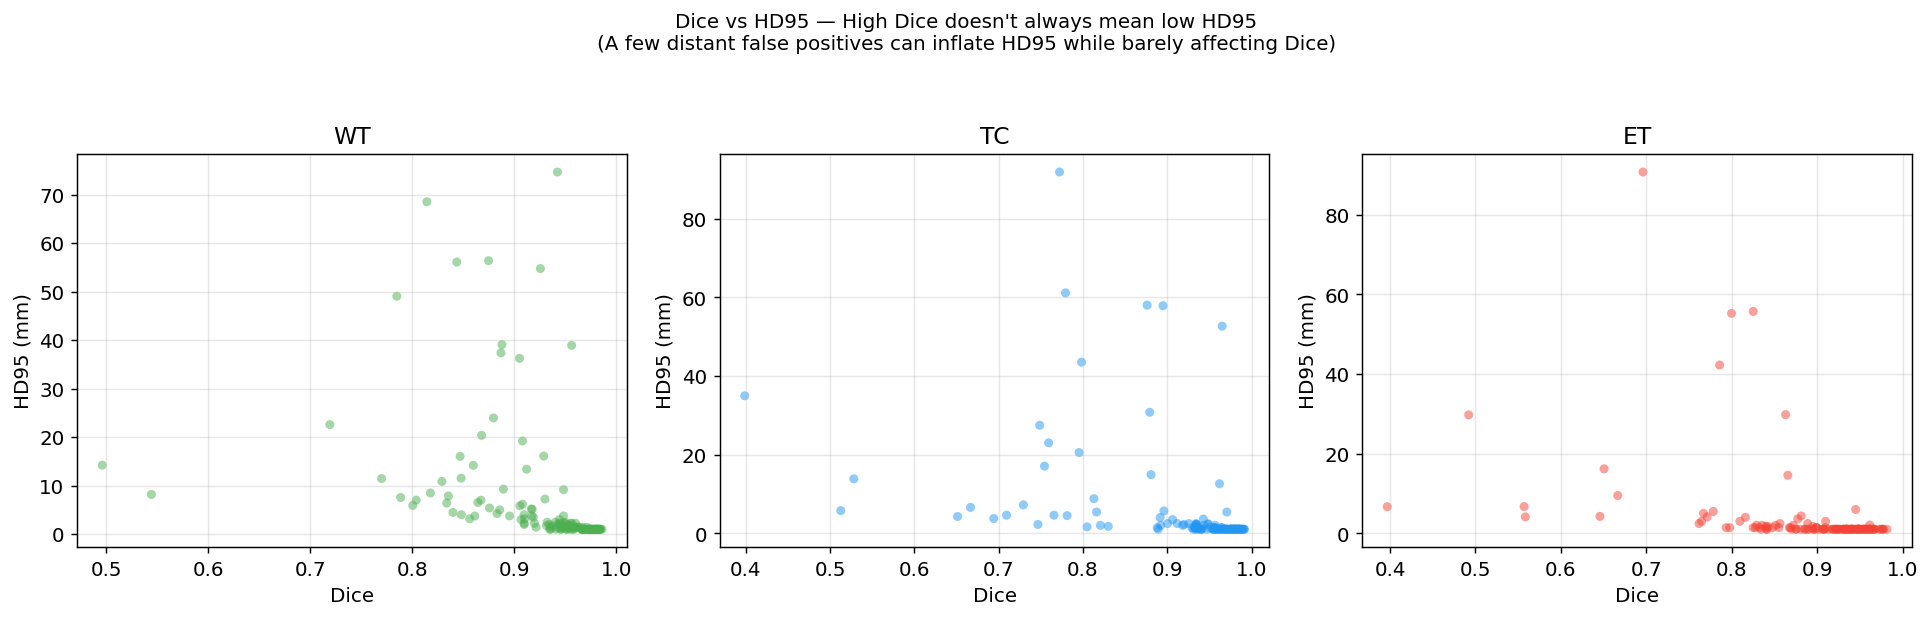

In [20]:
# Dice vs HD95 — understanding metric complementarity

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, region in zip(axes, ["WT", "TC", "ET"]):
    rdf = df_cases[df_cases["region"] == region].copy()
    rdf = rdf.replace([np.inf, -np.inf], np.nan).dropna(subset=["hd95"])
    ax.scatter(rdf["dice"], rdf["hd95"], c=REGION_COLORS[region],
              alpha=0.5, s=25, edgecolors="none")
    ax.set_xlabel("Dice"); ax.set_ylabel("HD95 (mm)")
    ax.set_title(f"{region}"); ax.grid(alpha=0.3)

fig.suptitle("Dice vs HD95 — High Dice doesn't always mean low HD95\n"
             "(A few distant false positives can inflate HD95 while barely affecting Dice)",
             fontsize=11, y=1.05)
plt.tight_layout()
plt.show()

### 5.3 Metrics Explained

| Metric | What It Measures | Range | In This Project |
|--------|-----------------|-------|----------------|
| **Dice** | Overlap between prediction and ground truth | 0–1 (1=perfect) | 0.913 mean |
| **IoU** | Intersection / Union (stricter than Dice) | 0–1 | Consistent with Dice |
| **HD95** | 95th percentile Hausdorff distance (boundary error in mm) | 0–\u221e (0=perfect) | Measures worst-case boundary accuracy |
| **Sensitivity** | True positive rate (how much tumor was detected) | 0–1 | High = few missed regions |

---
<a id='6'></a>
## 6. Transferability to CryoFIB-SEM / AFM

### 6.1 Direct Skill Transfer

| Skill Demonstrated | Brain MRI (This Project) | CryoFIB-SEM / AFM Application |
|-------------------|--------------------------|-------------------------------|
| **3D volumetric processing** | 240\u00d7240\u00d7155 MRI volumes | Serial FIB-SEM sections \u2192 3D stack |
| **Intensity correction** | N4 bias field (B-spline) | Charging artifacts, curtaining, beam damage |
| **Edge-preserving denoising** | Curvature flow diffusion | Shot noise in low-dose EM |
| **Multi-modal registration** | T1 \u2194 FLAIR \u2194 T1ce (Mutual Information) | FIB-SEM \u2194 AFM \u2194 fluorescence alignment |
| **3D deep learning segmentation** | 3D U-Net with sliding window | Organelle / membrane segmentation |
| **Patch-based processing** | 128\u00b3 patches, Gaussian blending | Essential for large EM stacks (TB-scale) |
| **Quantitative evaluation** | Dice, HD95, IoU per structure | Same metrics for EM segmentation benchmarks |

### 6.2 What I'd Do Differently for EM Data

| Challenge | MRI Approach | EM-Specific Adaptation |
|-----------|-------------|------------------------|
| **Anisotropic resolution** | Resample to 1mm isotropic | Z-step \u226b XY pixel size \u2192 anisotropic convolutions or super-resolution |
| **Annotation scarcity** | 731 fully labeled volumes | Semi-supervised / self-supervised pretraining |
| **Data scale** | ~30MB per case | TB-scale stacks \u2192 streaming / out-of-core processing |
| **Non-rigid deformation** | Rigid registration (sufficient for MRI) | Section warping needs deformable registration (B-spline FFD) |
| **Artifact types** | RF inhomogeneity | Curtaining, charging, redeposition \u2192 domain-specific correction |

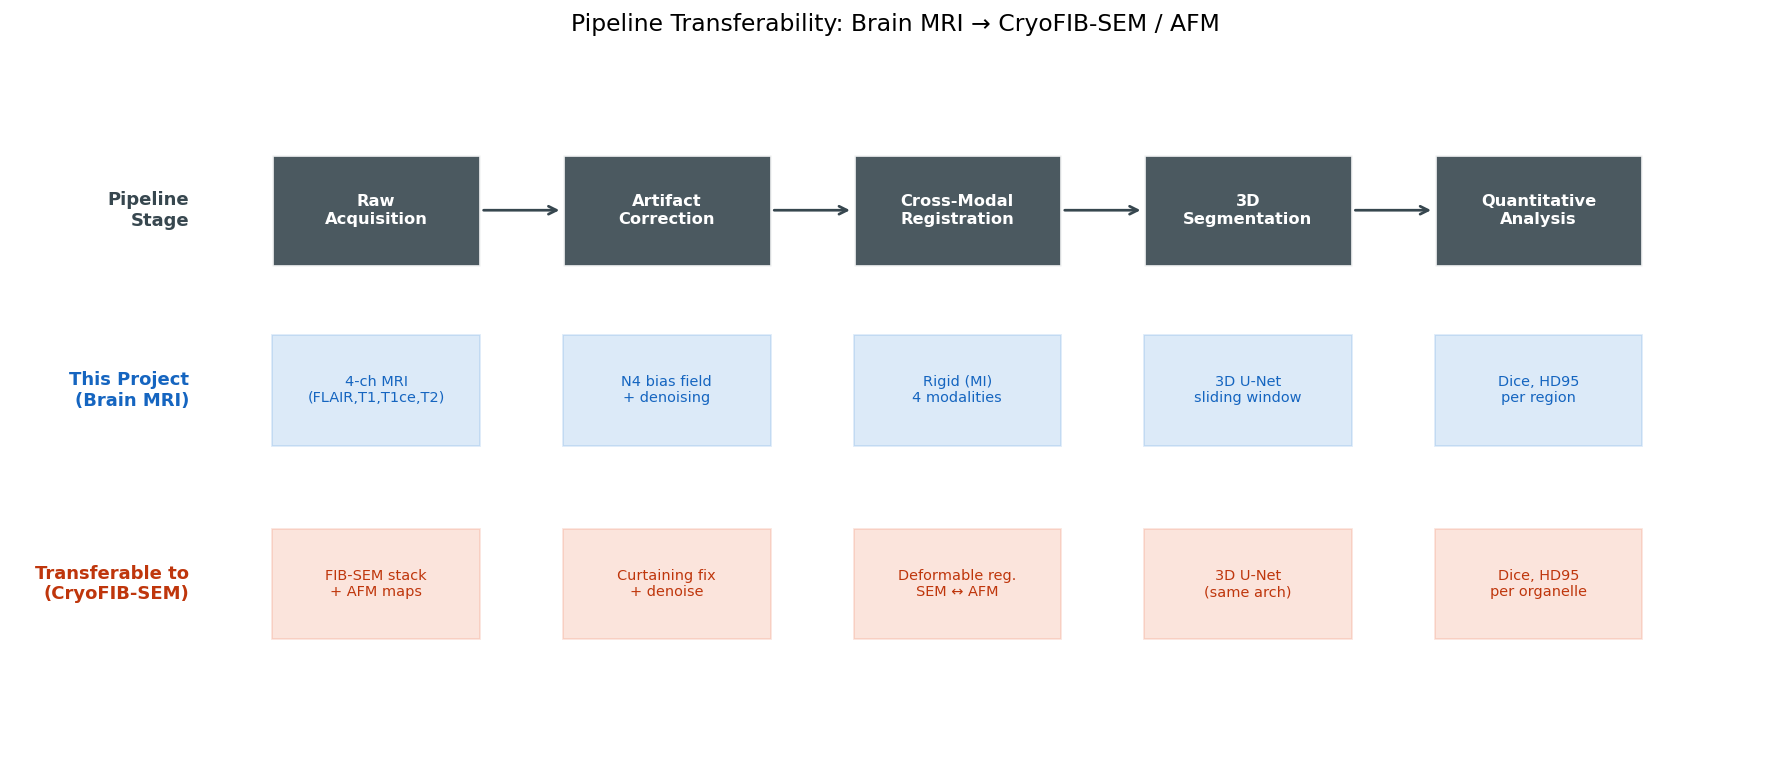

In [21]:
# Pipeline comparison diagram

fig, ax = plt.subplots(figsize=(14, 6))
ax.axis("off")

steps = ["Raw\nAcquisition", "Artifact\nCorrection", "Cross-Modal\nRegistration",
         "3D\nSegmentation", "Quantitative\nAnalysis"]
mri_details = ["4-ch MRI\n(FLAIR,T1,T1ce,T2)", "N4 bias field\n+ denoising",
               "Rigid (MI)\n4 modalities", "3D U-Net\nsliding window",
               "Dice, HD95\nper region"]
em_details = ["FIB-SEM stack\n+ AFM maps", "Curtaining fix\n+ denoise",
              "Deformable reg.\nSEM \u2194 AFM", "3D U-Net\n(same arch)",
              "Dice, HD95\nper organelle"]

y_step, y_mri, y_em = 3.5, 2.2, 0.8
box_w, box_h = 2.0, 0.8

for i, step in enumerate(steps):
    x = i * 2.8 + 0.5
    # Step box
    rect = plt.Rectangle((x, y_step), box_w, box_h, facecolor="#37474F",
                          edgecolor="white", lw=1.5, alpha=0.9)
    ax.add_patch(rect)
    ax.text(x + box_w/2, y_step + box_h/2, step, ha="center", va="center",
            fontsize=9, color="white", fontweight="bold")
    # Arrow to next
    if i < len(steps) - 1:
        ax.annotate("", xy=(x + box_w + 0.8, y_step + box_h/2),
                    xytext=(x + box_w, y_step + box_h/2),
                    arrowprops=dict(arrowstyle="->", lw=1.5, color="#37474F"))
    # MRI row
    rect = plt.Rectangle((x, y_mri), box_w, box_h, facecolor="#1976D2",
                          alpha=0.15, edgecolor="#1976D2", lw=1)
    ax.add_patch(rect)
    ax.text(x + box_w/2, y_mri + box_h/2, mri_details[i], ha="center", va="center",
            fontsize=8, color="#1565C0")
    # EM row
    rect = plt.Rectangle((x, y_em), box_w, box_h, facecolor="#E64A19",
                          alpha=0.15, edgecolor="#E64A19", lw=1)
    ax.add_patch(rect)
    ax.text(x + box_w/2, y_em + box_h/2, em_details[i], ha="center", va="center",
            fontsize=8, color="#BF360C")

# Row labels
ax.text(-0.3, y_step + box_h/2, "Pipeline\nStage", ha="right", va="center",
        fontsize=10, fontweight="bold", color="#37474F")
ax.text(-0.3, y_mri + box_h/2, "This Project\n(Brain MRI)", ha="right", va="center",
        fontsize=10, fontweight="bold", color="#1565C0")
ax.text(-0.3, y_em + box_h/2, "Transferable to\n(CryoFIB-SEM)", ha="right", va="center",
        fontsize=10, fontweight="bold", color="#BF360C")

ax.set_xlim(-2, 15)
ax.set_ylim(0, 5)
ax.set_title("Pipeline Transferability: Brain MRI \u2192 CryoFIB-SEM / AFM",
             fontsize=13, pad=15)
plt.tight_layout()
plt.show()

### 6.3 Summary

| | |
|---|---|
| **What I built** | End-to-end 3D multi-modal image processing and segmentation pipeline |
| **Core competencies** | 3D volumetric processing, artifact correction, cross-modal registration, deep learning segmentation, quantitative evaluation |
| **Technical depth** | Custom transforms, mixed-precision training, sliding-window inference, multi-metric evaluation on 147 cases |
| **Result** | Dice = 0.913 across 3 segmentation targets |
| **Transferability** | Same pipeline architecture applies to cryoFIB-SEM + AFM with domain-specific adaptations |

---

*Full source code, trained models, and detailed documentation available at the project repository.*

In [22]:
print("\n" + "="*60)
print("  Presentation Complete")
print("  Pipeline: Correction \u2192 Registration \u2192 Segmentation \u2192 Evaluation")
print("  Result: Dice = 0.913 on 147 validation cases")
print("  Transferable to cryoFIB-SEM / AFM workflows")
print("="*60)


  Presentation Complete
  Pipeline: Correction → Registration → Segmentation → Evaluation
  Result: Dice = 0.913 on 147 validation cases
  Transferable to cryoFIB-SEM / AFM workflows
